In [1]:
# Imports pour l'analyse de modèles de reconnaissance d'image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re

# Configuration pour de meilleurs graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Configuration des options d'affichage pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# --- CONFIGURATION ---
versions = ["results-wave03", "results-wave02", "results-wave01"]
base_folder = "../models/robot/"
metrics_folder = "metrics"
csv_files = ["best_epoch.csv", "train_accuracy.csv", "train_loss.csv", "val_accuracy.csv", "val_loss.csv"]

In [2]:
# --- FONCTION UTILITAIRE : Extraction Métadonnées ---
def extract_all_params(model_name):
    name_lower = model_name.lower()
    
    # FAMILLE
    family = 'Autre'
    if 'resnet18' in name_lower: family = 'ResNet18'
    elif 'resnet34' in name_lower: family = 'ResNet34'
    elif 'mobilenet_v2' in name_lower: family = 'MobileNetV2'
    elif 'mobilenet_v3' in name_lower: family = 'MobileNetV3'
    elif 'efficientnet' in name_lower: family = 'EfficientNet'

    # BATCH SIZE
    batch_match = re.search(r'[_ -]b(\d+)', name_lower)
    if not batch_match: batch_match = re.search(r'b(\d+)', name_lower)
    batch_size = int(batch_match.group(1)) if batch_match else 0
    batch_str = f"b{batch_size}" if batch_size > 0 else "Inconnu"

    # LEARNING RATE
    lr_match = re.search(r'lr([0-9.e-]+)', name_lower)
    lr_val = 'Inconnu'
    if lr_match:
        raw_lr = lr_match.group(1).rstrip('_')
        try:
            float_lr = float(raw_lr)
            lr_val = f"{float_lr:.0e}" 
        except:
            lr_val = raw_lr

    return pd.Series([family, batch_str, lr_val], index=['Family', 'BatchSize', 'LearningRate'])

In [3]:
# --- 1. CHARGEMENT DES DONNÉES (TOUTES VERSIONS) ---
all_results = {}

print(f"{'='*50}\n CHARGEMENT GLOBAL\n{'='*50}")

for version in versions:
    models_folder = Path(base_folder) / version
    if not models_folder.exists():
        print(f"⚠️ Dossier non trouvé : {models_folder}")
        continue
        
    model_list = [f.name for f in models_folder.iterdir() if f.is_dir()]
    
    # Chargement best_epochs
    best_epochs = {}
    for model in model_list:
        p = models_folder / model / metrics_folder / "best_epoch.csv"
        if p.exists():
            best_epochs[model] = pd.read_csv(p, header=None).iloc[0, 0]
            
    # Construction results_df
    model_metrics = {}
    for model in model_list:
        if model not in best_epochs: continue
        
        model_metrics[model] = {}
        best_epoch = best_epochs[model]
        model_metrics[model]['best_epoch'] = best_epoch
        
        for csv_file in csv_files:
            if csv_file == "best_epoch.csv": continue
            metric_path = models_folder / model / metrics_folder / csv_file
            if metric_path.exists():
                metric_df = pd.read_csv(metric_path, header=None)
                if best_epoch < len(metric_df):
                    metric_name = csv_file.replace('.csv', '')
                    model_metrics[model][metric_name] = metric_df.iloc[best_epoch, 0]
    
    version_df = pd.DataFrame(model_metrics).T
    
    # Enrichment avec métadonnées tout de suite
    if not version_df.empty:
        meta_data = version_df.index.to_series().apply(extract_all_params)
        version_df = pd.concat([version_df, meta_data], axis=1)
        all_results[version] = version_df
        print(f"✅ {version} : {len(version_df)} modèles chargés.")
    else:
         print(f"❌ {version} : Aucune donnée.")

 CHARGEMENT GLOBAL
✅ results-wave03 : 24 modèles chargés.
✅ results-wave02 : 12 modèles chargés.
✅ results-wave01 : 60 modèles chargés.


In [4]:
for version, full_df in all_results.items():
    print(f"\n{'='*100}")
    print(f" TOP 5 : {version}")
    print(f"{'='*100}\n")
    
    # Affichage tableau Top 5
    print(full_df.sort_values('val_accuracy', ascending=False).head(5)[['val_accuracy', 'val_loss', 'Family', 'BatchSize', 'LearningRate']])


 TOP 5 : results-wave03

                              val_accuracy  val_loss       Family BatchSize  \
mobilenet_v2_b32_lr0.001_e20       95.3488    0.1457  MobileNetV2       b32   
mobilenet_v2_b32_lr0.01_e40        94.1860    0.1484  MobileNetV2       b32   
mobilenet_v2_b32_lr0.001_e30       94.1860    0.1690  MobileNetV2       b32   
mobilenet_v2_b32_lr0.001_e40       94.1860    0.1277  MobileNetV2       b32   
resnet18_b32_lr0.01_e30            94.1860    0.1842     ResNet18       b32   

                             LearningRate  
mobilenet_v2_b32_lr0.001_e20        1e-03  
mobilenet_v2_b32_lr0.01_e40         1e-02  
mobilenet_v2_b32_lr0.001_e30        1e-03  
mobilenet_v2_b32_lr0.001_e40        1e-03  
resnet18_b32_lr0.01_e30             1e-02  

 TOP 5 : results-wave02

                               val_accuracy  val_loss       Family BatchSize  \
mobilenet_v2_b32_lr0.01_e150        94.1860    0.1503  MobileNetV2       b32   
mobilenet_v2_b16_lr0.01_e150        93.0233    0.

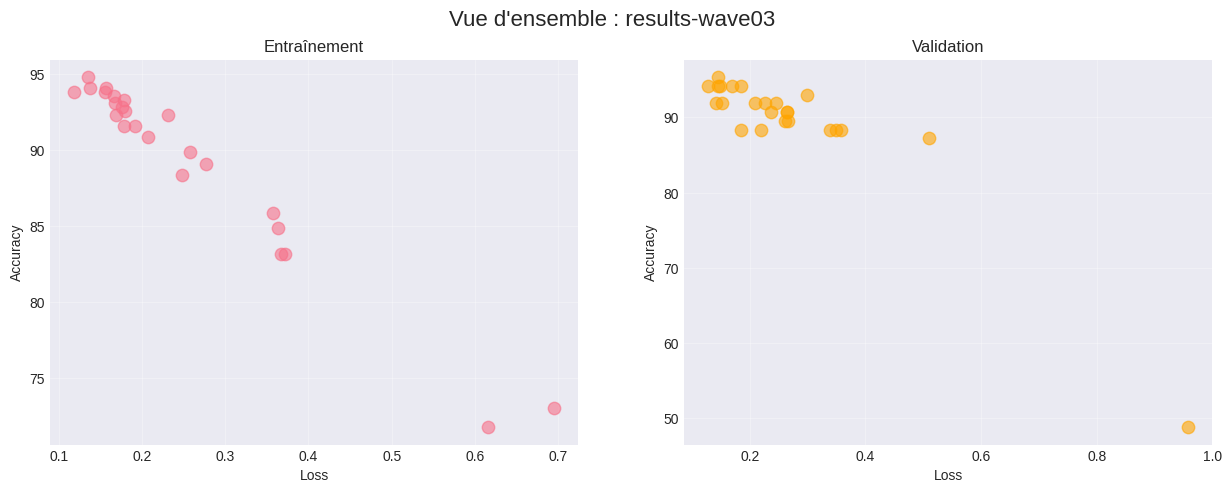

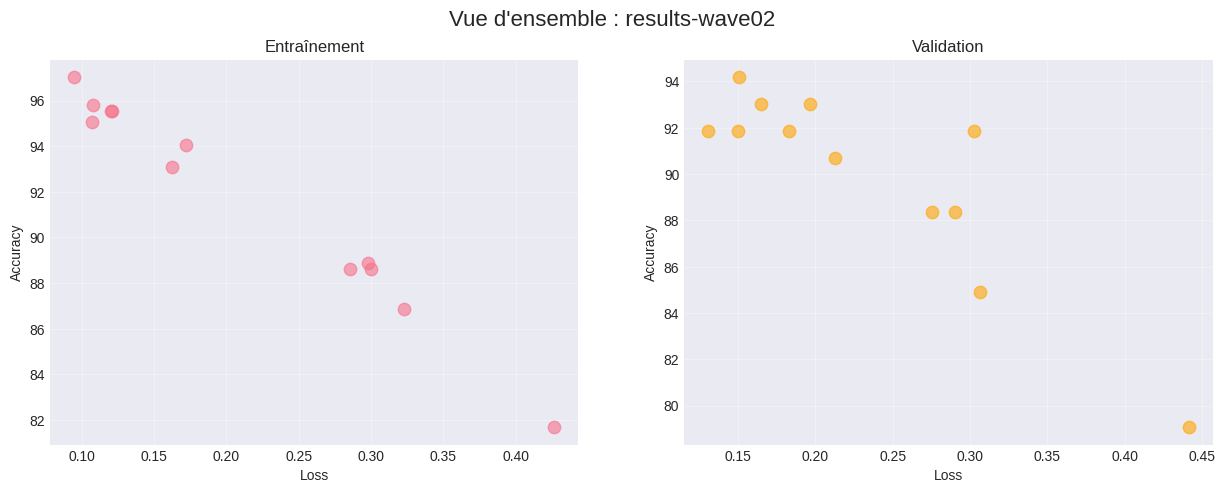

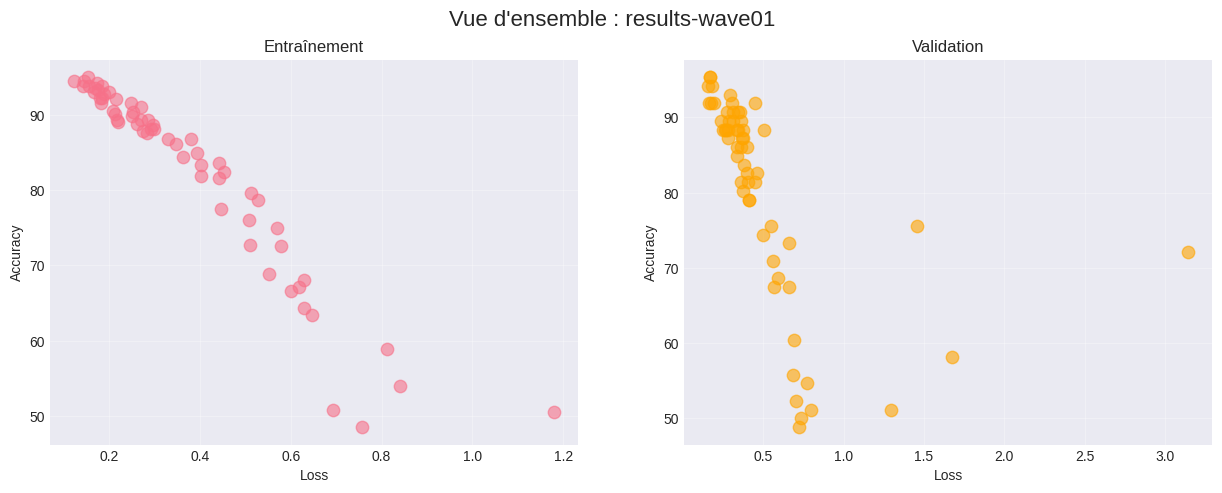

In [5]:
# --- 2. AFFICHAGE DES GRAPHIQUES ---
for version, full_df in all_results.items():

    # --- Graphique 1 : Vue d'ensemble ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f"Vue d'ensemble : {version}", fontsize=16)
    
    ax1.scatter(full_df['train_loss'], full_df['train_accuracy'], s=80, alpha=0.6)
    ax1.set_title('Entraînement'); ax1.set_xlabel('Loss'); ax1.set_ylabel('Accuracy')
    ax1.grid(True, alpha=0.3)
    
    ax2.scatter(full_df['val_loss'], full_df['val_accuracy'], s=80, alpha=0.6, color='orange')
    ax2.set_title('Validation'); ax2.set_xlabel('Loss'); ax2.set_ylabel('Accuracy')
    ax2.grid(True, alpha=0.3)
    plt.show()

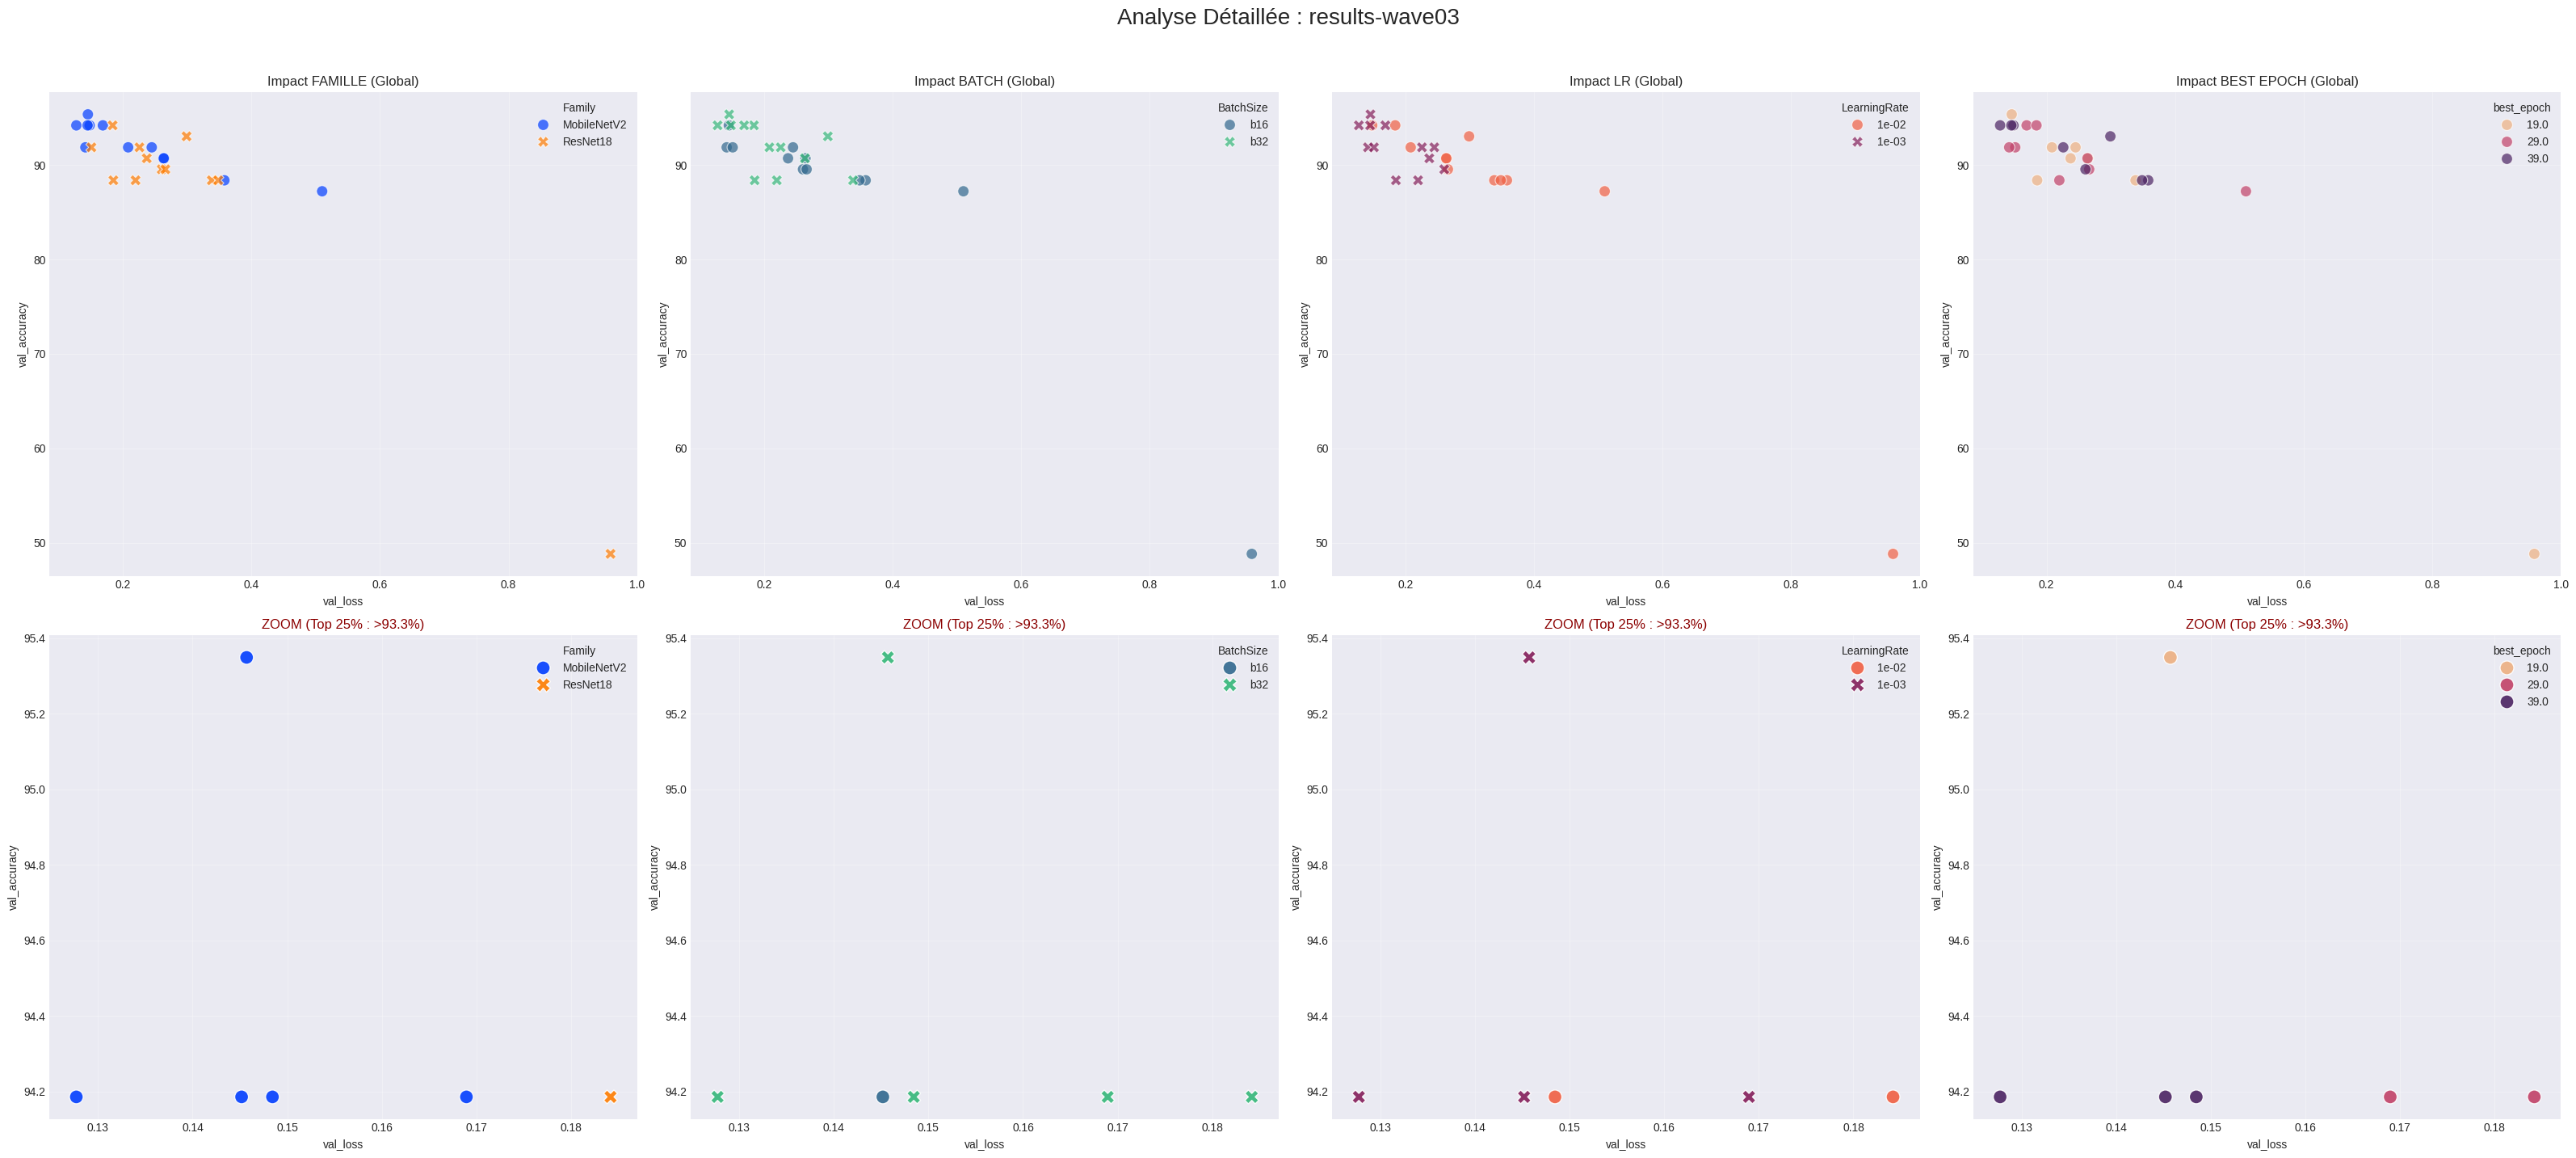

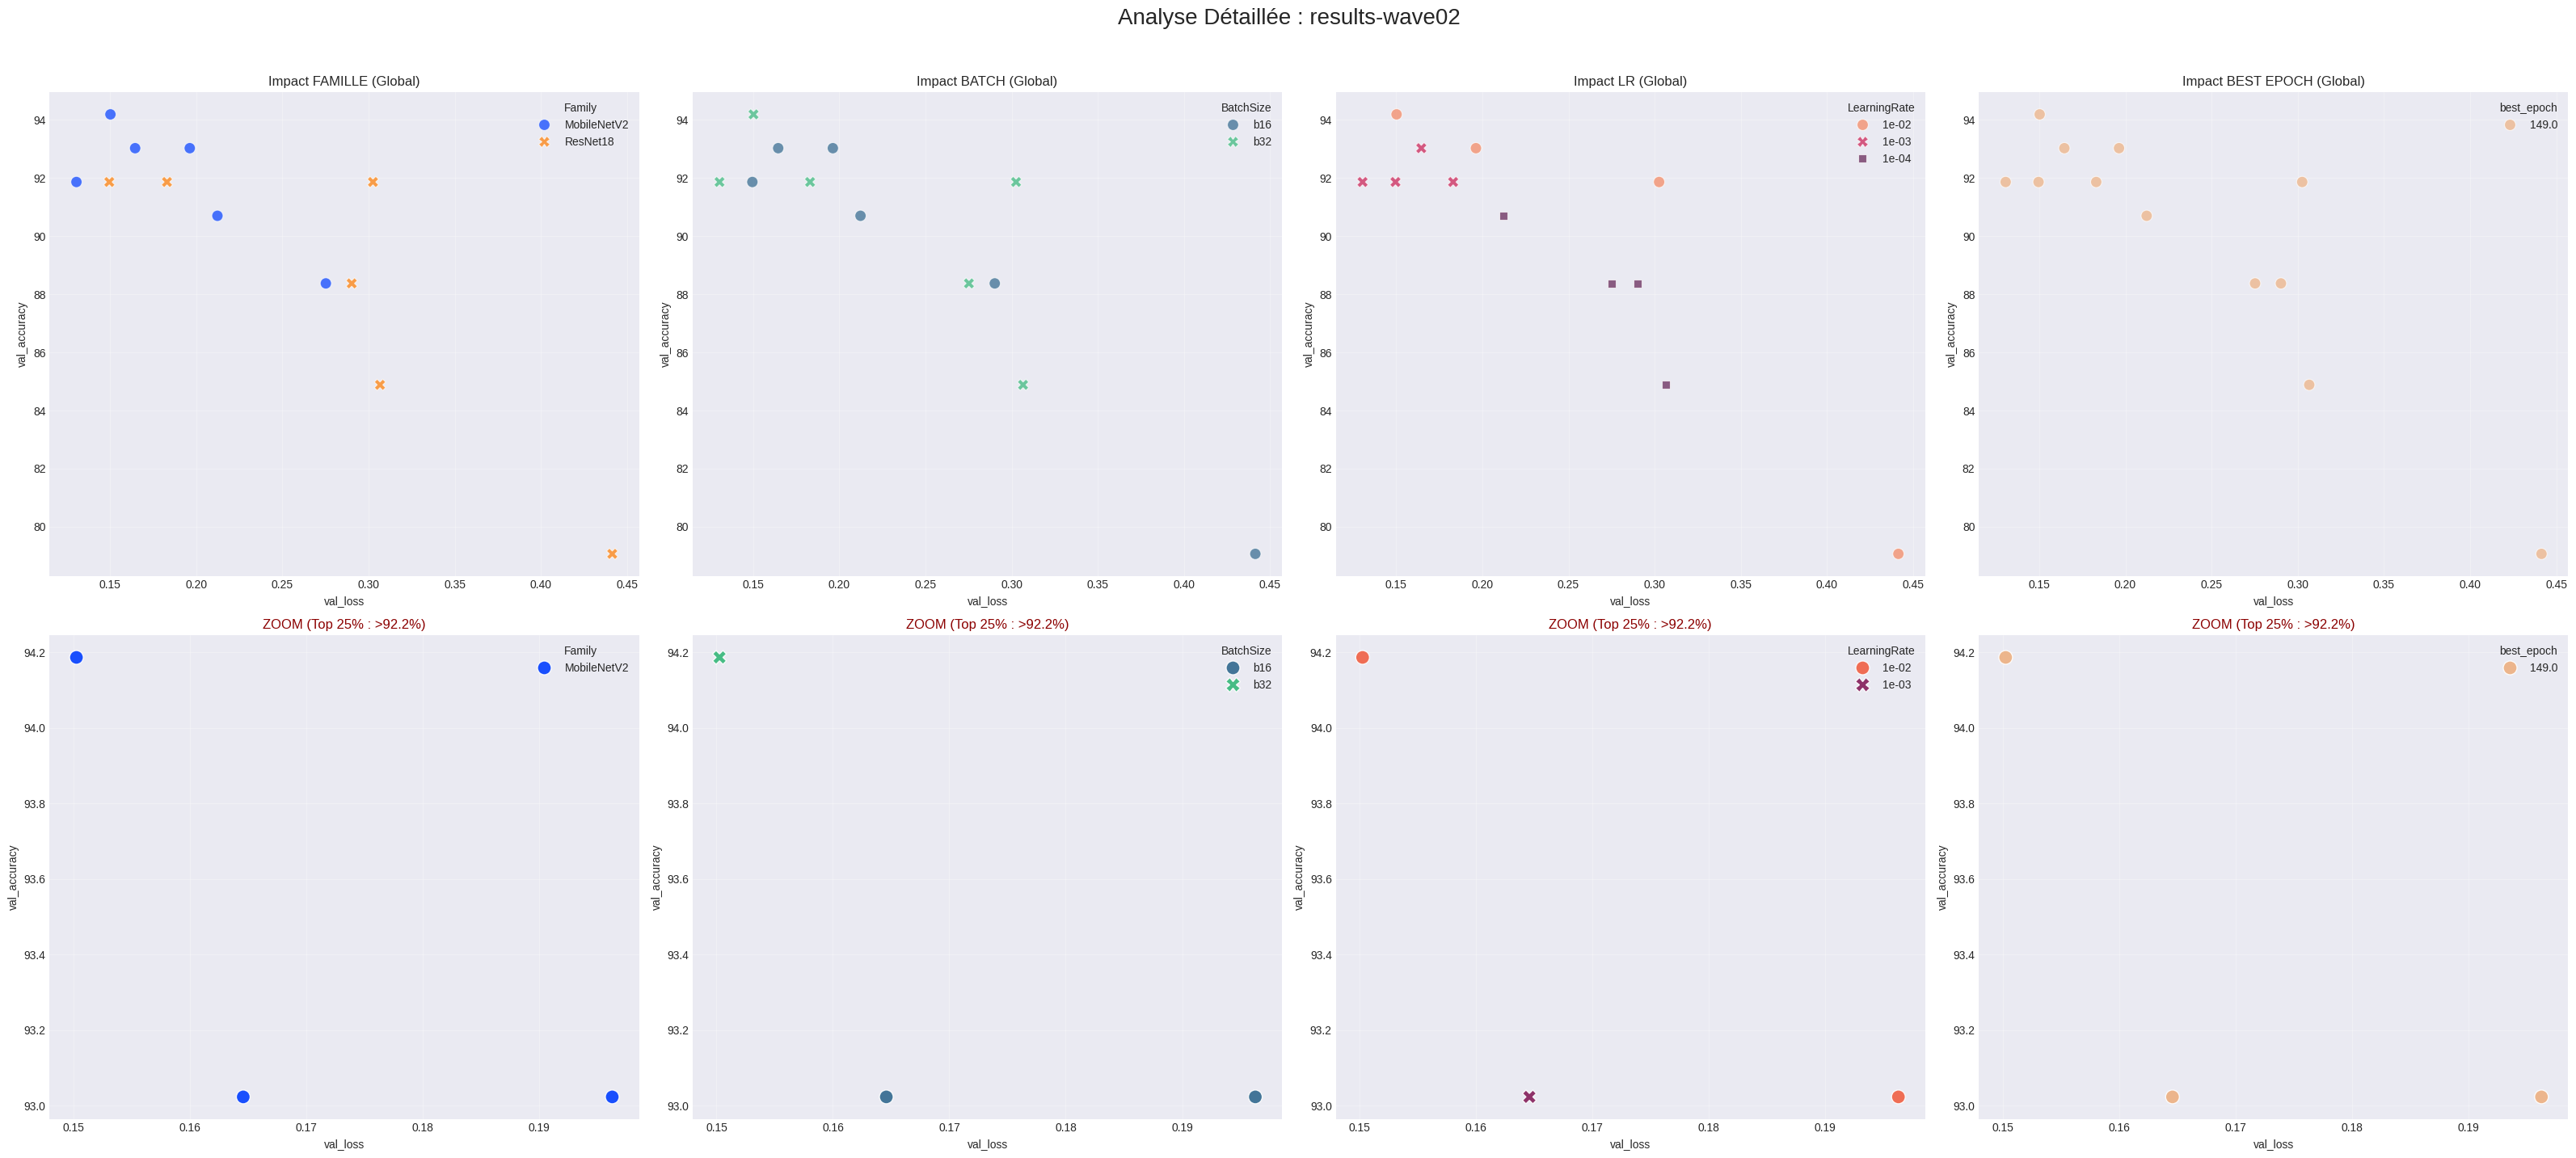

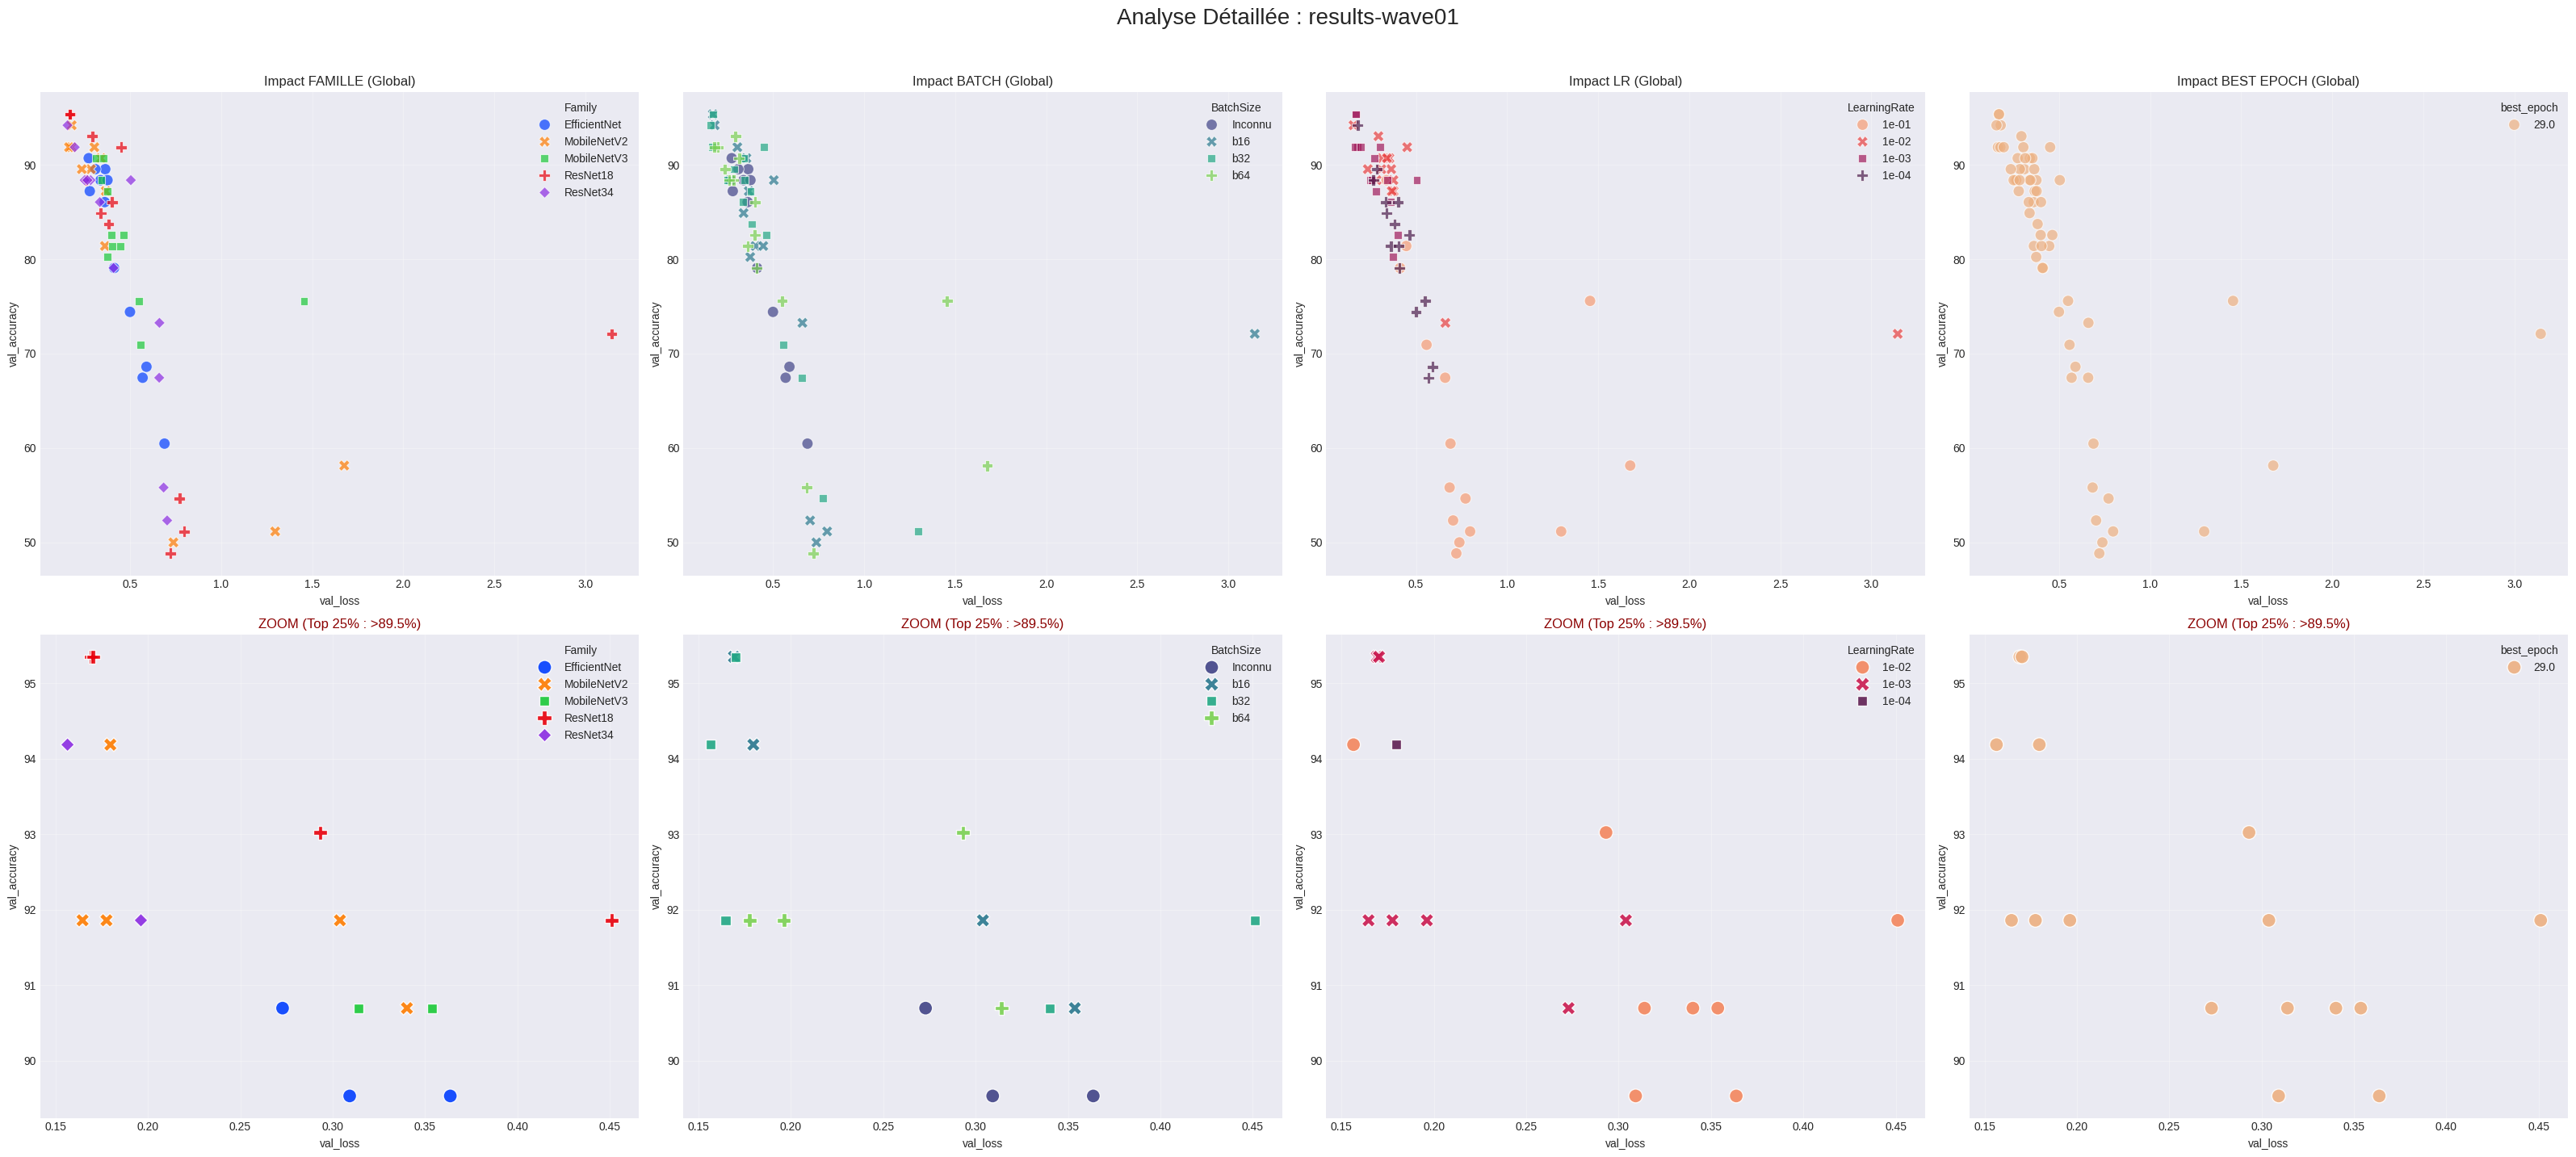

In [6]:
for version, full_df in all_results.items():
    # --- Graphique 2 : Grille détaillée ---
    acc_threshold = full_df['val_accuracy'].quantile(0.75)
    zoom_df = full_df[full_df['val_accuracy'] >= acc_threshold].copy()

    fig, axes = plt.subplots(2, 4, figsize=(32, 14))
    plot_configs = [
        {'col': 'Family',       'title': 'Impact FAMILLE',    'palette': 'bright'},
        {'col': 'BatchSize',    'title': 'Impact BATCH',      'palette': 'viridis'},
        {'col': 'LearningRate', 'title': 'Impact LR',         'palette': 'rocket_r'},
        {'col': 'best_epoch',   'title': 'Impact BEST EPOCH', 'palette': 'flare'}
    ]
    
    for i, config in enumerate(plot_configs):
        col_name = config['col']
        current_full = full_df.sort_values(col_name)
        current_zoom = zoom_df.sort_values(col_name) if not zoom_df.empty else pd.DataFrame()
        style_param = col_name if col_name != 'best_epoch' else None

        # Haut
        if not current_full.empty:
            sns.scatterplot(data=current_full, x='val_loss', y='val_accuracy', hue=col_name, style=style_param, s=100, alpha=0.7, palette=config['palette'], ax=axes[0, i])
            # Légende uniquement si nécessaire
            if axes[0, i].legend_: axes[0, i].legend(title=col_name)
        axes[0, i].set_title(f"{config['title']} (Global)")
        axes[0, i].grid(True, alpha=0.3)

        # Bas
        if not current_zoom.empty:
            sns.scatterplot(data=current_zoom, x='val_loss', y='val_accuracy', hue=col_name, style=style_param, s=150, alpha=0.9, palette=config['palette'], ax=axes[1, i])
            axes[1, i].set_title(f"ZOOM (Top 25% : >{acc_threshold:.1f}%)", color='darkred')
        else:
             axes[1, i].text(0.5, 0.5, "Pas de données", ha='center')
        axes[1, i].grid(True, alpha=0.3)
        
    plt.suptitle(f"Analyse Détaillée : {version}", fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()

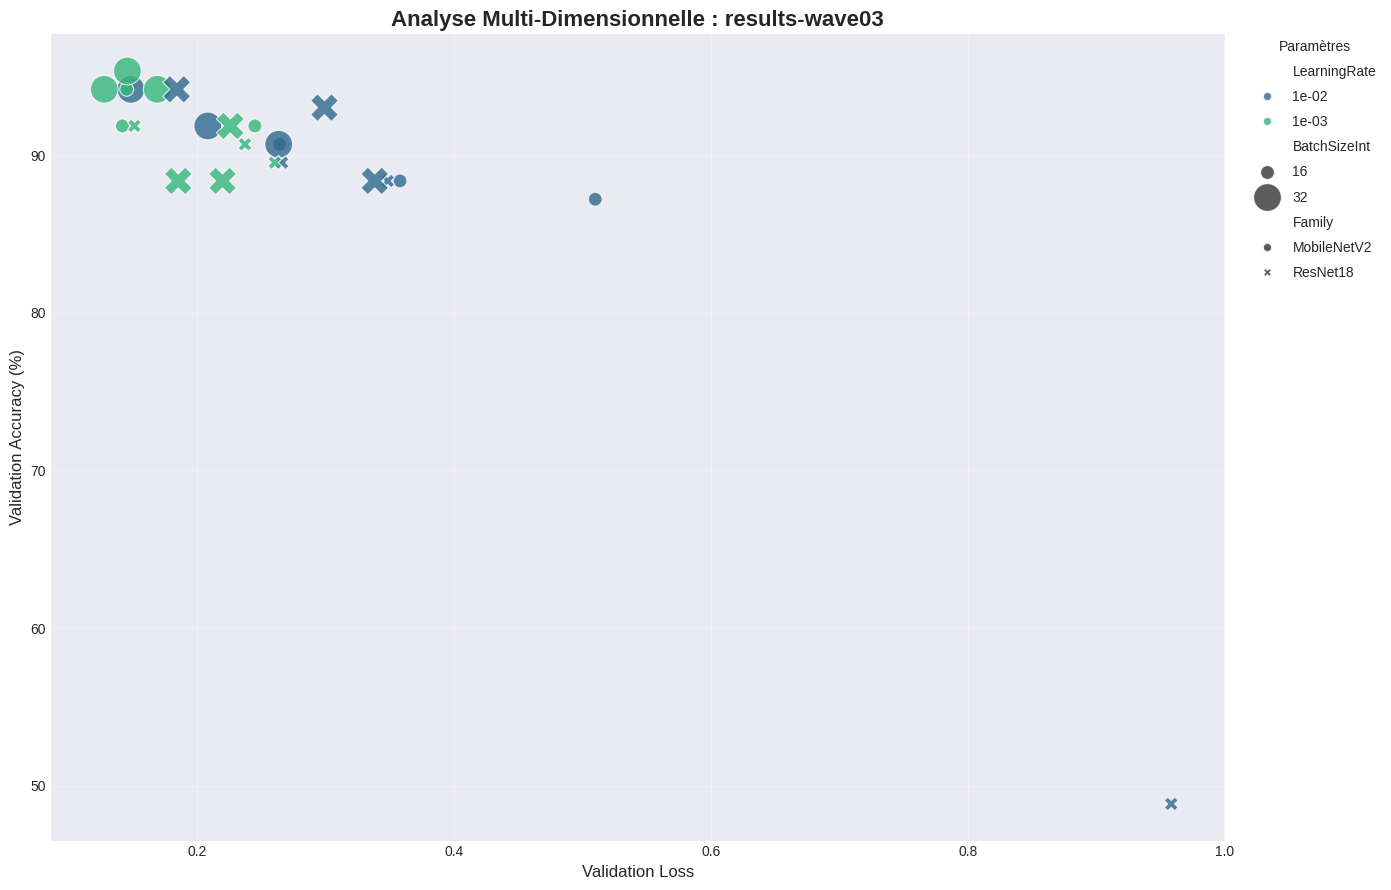

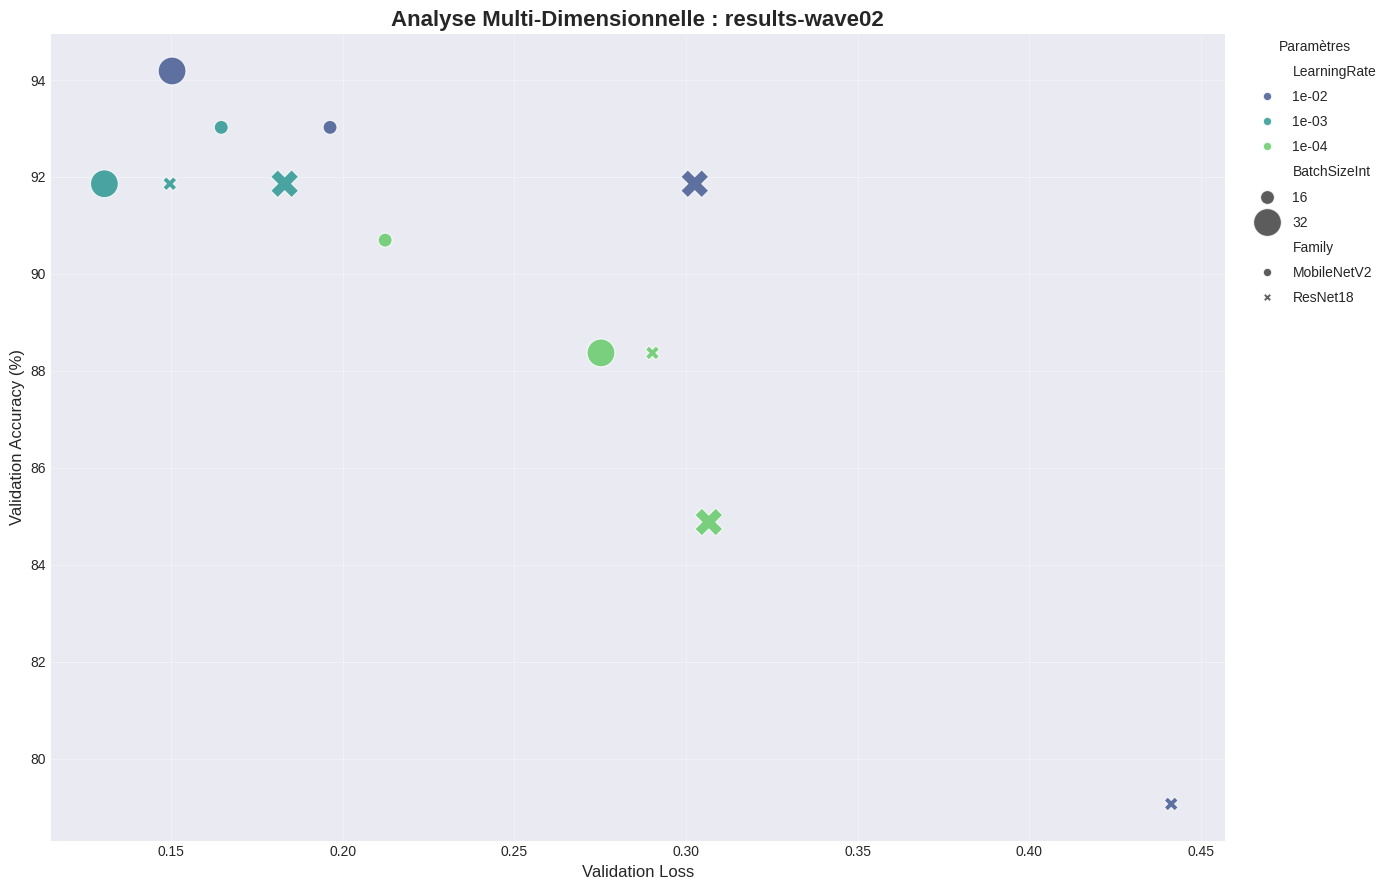

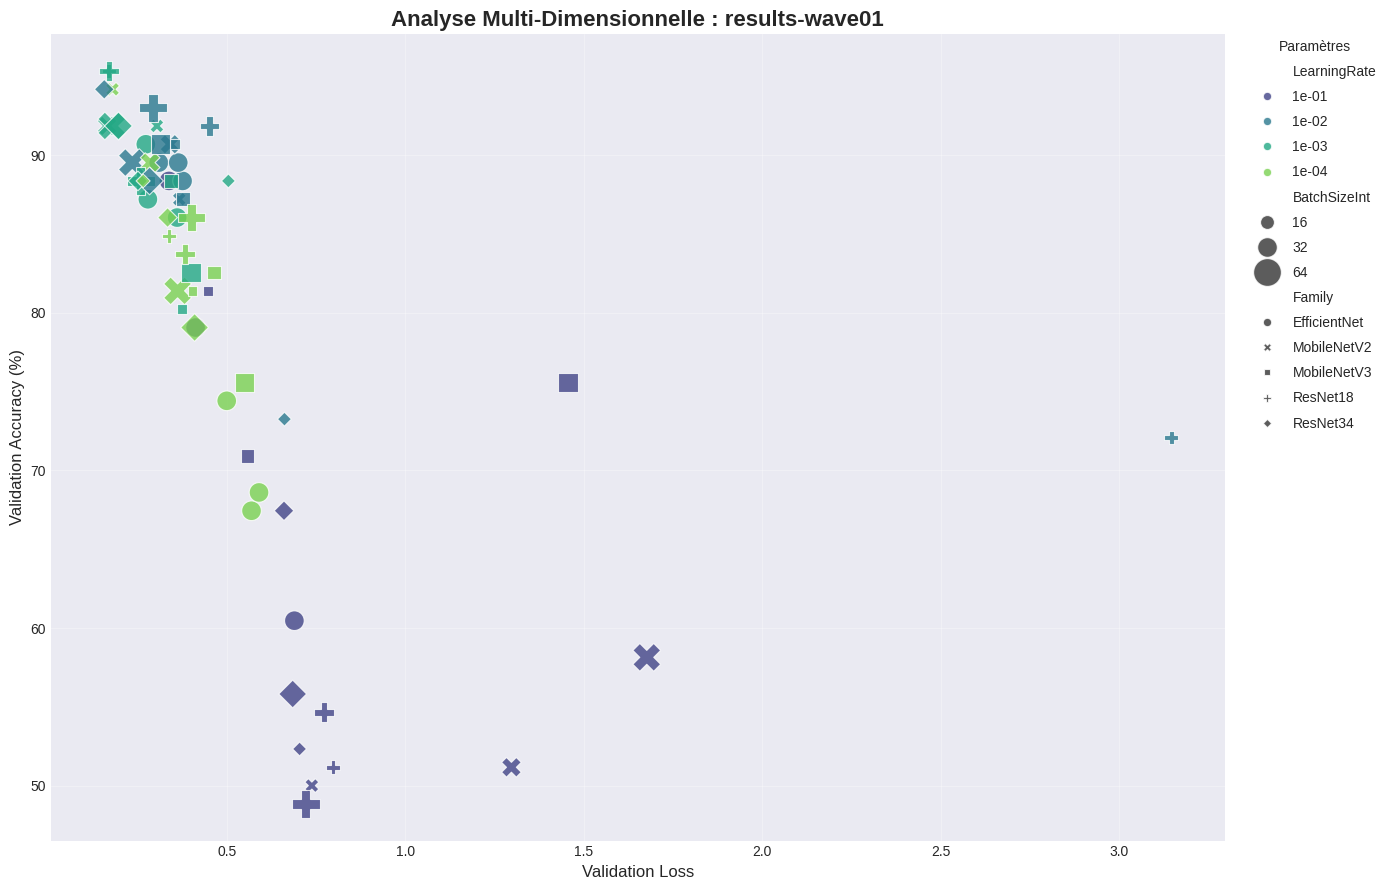

In [7]:
for version, full_df in all_results.items():
    # --- Graphique 3 : Analyse Multi-Dimensionnelle (Votre demande) ---
    plt.figure(figsize=(14, 9))
    
    # On s'assure que les colonnes sont bien présentes (BatchSize est parfois une chaîne 'b32', on veut un entier pour la taille des points)
    # Conversion temporaire pour le graphique
    plot_df = full_df.copy()
    
    # Nettoyage de BatchSize pour avoir des entiers (nécessaire pour le paramètre 'size' de seaborn)
    def clean_batch_size(val):
        if isinstance(val, str) and val.startswith('b'):
            try: return int(val[1:])
            except: return 0
        return val if isinstance(val, (int, float)) else 32

    plot_df['BatchSizeInt'] = plot_df['BatchSize'].apply(clean_batch_size)
    
    # Tri pour la légende
    plot_df = plot_df.sort_values(by=['Family', 'LearningRate', 'BatchSizeInt'])

    sns.scatterplot(
        data=plot_df,
        x='val_loss', 
        y='val_accuracy',
        style='Family',       # FORME = Famille
        hue='LearningRate',   # COULEUR = Learning Rate
        size='BatchSizeInt',  # TAILLE = Batch Size (entier)
        sizes=(100, 400),     # Plage de taille des points
        palette='viridis',    # Palette
        alpha=0.8
    )

    plt.xlabel('Validation Loss', fontsize=12)
    plt.ylabel('Validation Accuracy (%)', fontsize=12)
    plt.title(f'Analyse Multi-Dimensionnelle : {version}', fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3)

    # Légende optimisée à l'extérieur
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., labelspacing=0.8, title="Paramètres")

    plt.tight_layout()
    plt.show()

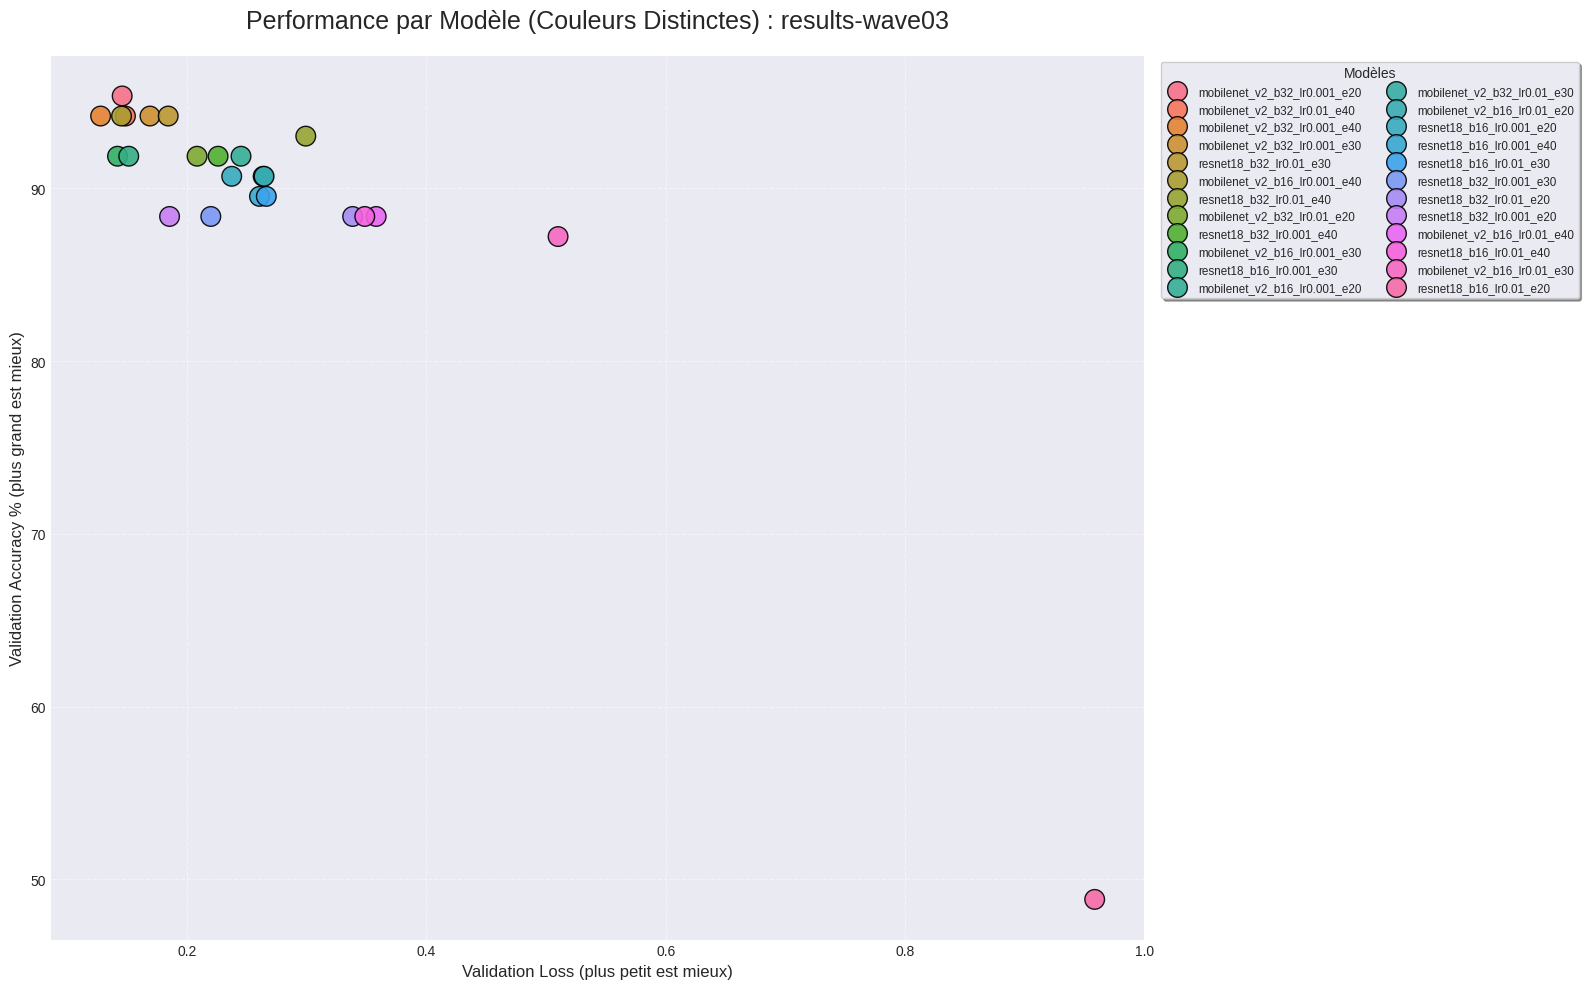

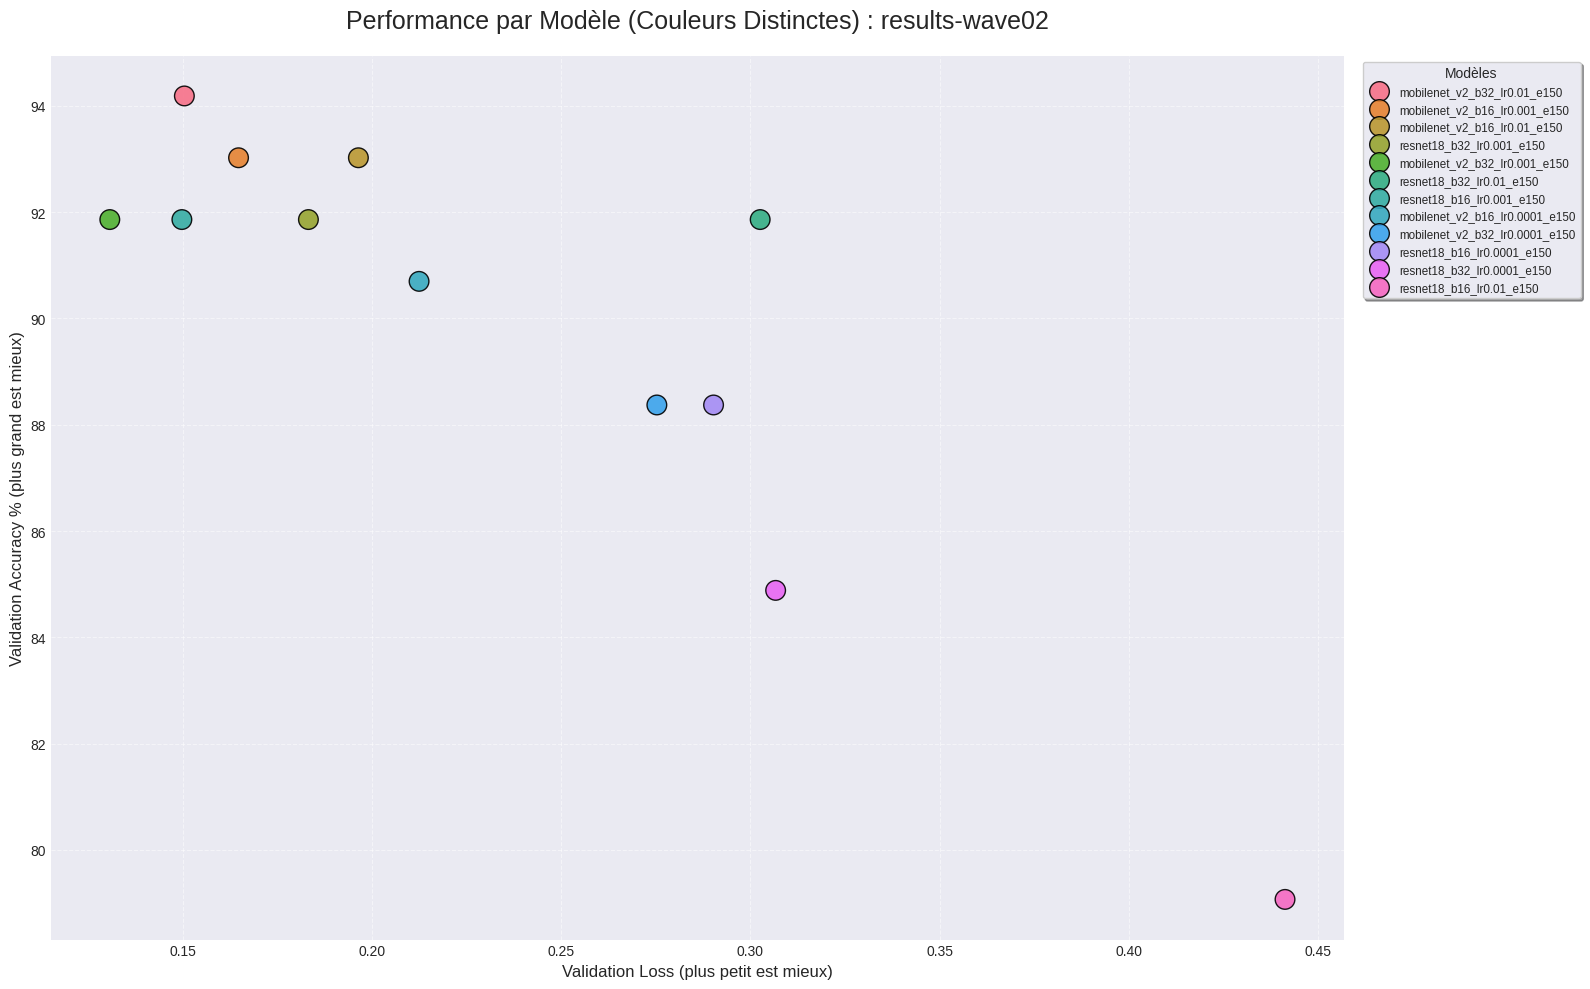

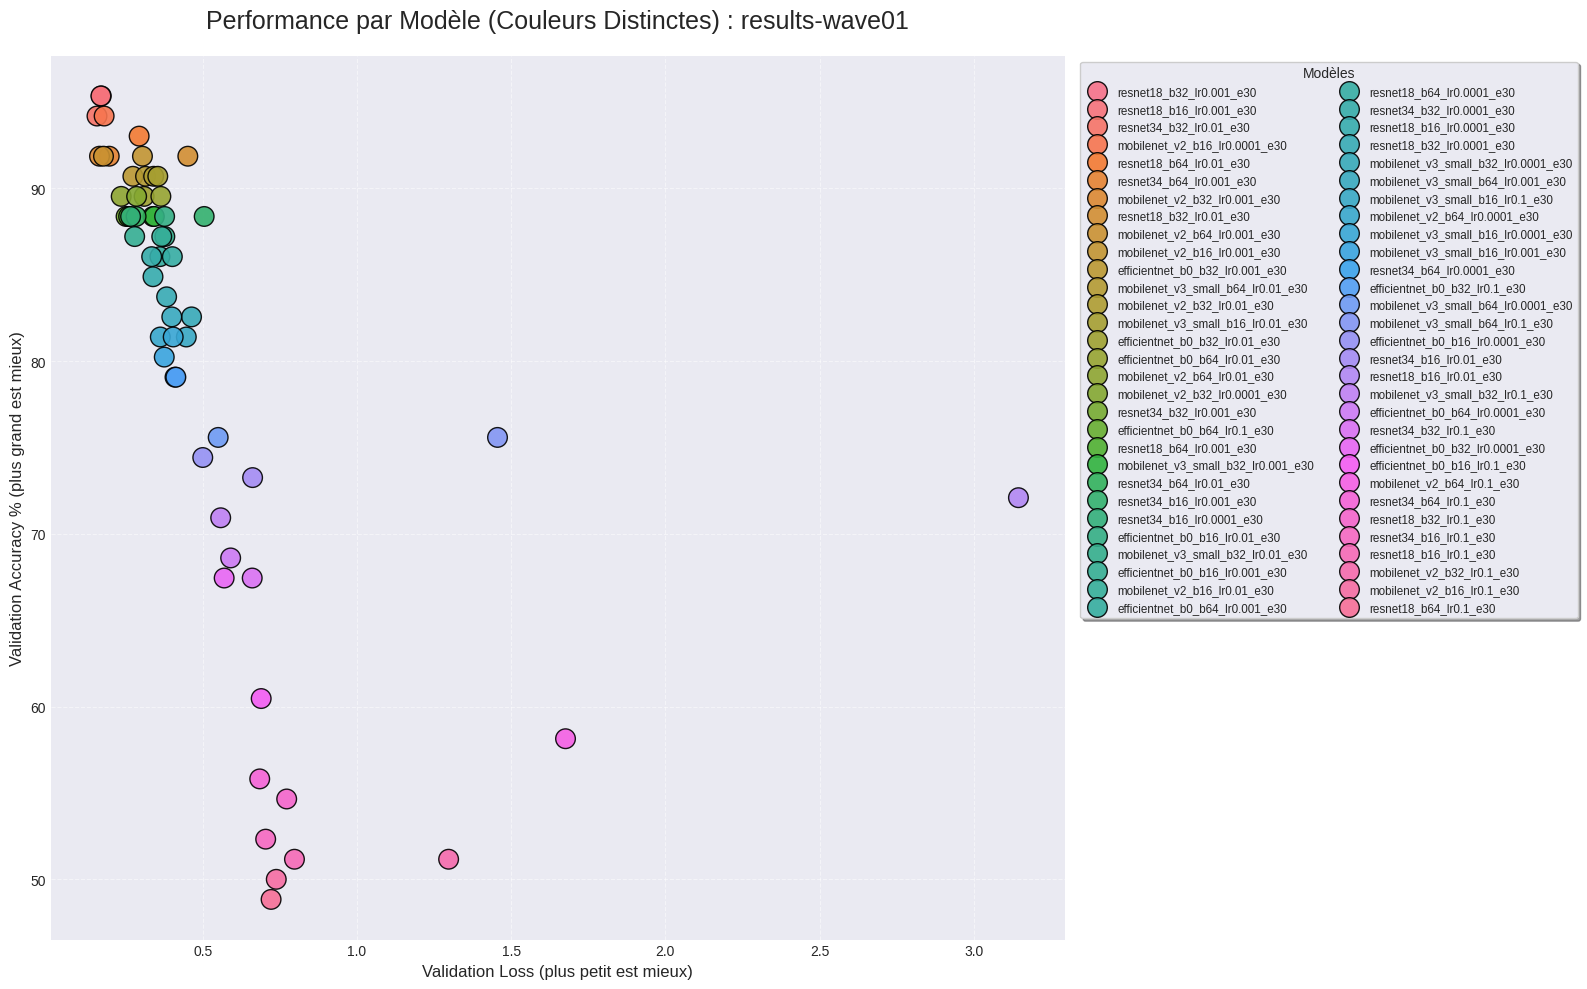

In [8]:
for version, full_df in all_results.items():
    plt.figure(figsize=(16, 10))
    
    # 1. Tri des modèles par performance
    ranked_df = full_df.sort_values(
        by=['val_accuracy', 'val_loss'], 
        ascending=[False, True]
    )
    
    # 2. Création du graphique avec des couleurs distinctes
    # Création d'une palette avec autant de couleurs distinctes que de modèles
    n_models = len(ranked_df)
    # 'husl' permet d'avoir des couleurs équidistantes dans le spectre visible
    distinct_palette = sns.color_palette("husl", n_models) 
    
    sns.scatterplot(
        data=ranked_df,
        x='val_loss', 
        y='val_accuracy',
        hue=ranked_df.index,
        hue_order=ranked_df.index,
        palette=distinct_palette, # Palette distincte
        s=200,
        edgecolor='black',
        linewidth=1,
        alpha=0.9
    )
    
    # 3. Annotations pour les Top 10
    # for i, (model_name, row) in enumerate(ranked_df.head(10).iterrows()):
    #      plt.annotate(
    #         f"{i+1}. {model_name}", 
    #         (row['val_loss'], row['val_accuracy']),
    #         xytext=(10, 10), textcoords='offset points',
    #         fontsize=9, fontweight='bold',
    #         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    #     )

    plt.title(f"Performance par Modèle (Couleurs Distinctes) : {version}", fontsize=18, pad=20)
    plt.xlabel("Validation Loss (plus petit est mieux)", fontsize=12)
    plt.ylabel("Validation Accuracy % (plus grand est mieux)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Légende placée à l'extérieur
    plt.legend(
        bbox_to_anchor=(1.01, 1), 
        loc='upper left', 
        title="Modèles", 
        fontsize='small',
        frameon=True,
        shadow=True,
        ncol=1 if n_models < 20 else 2 # Deux colonnes si beaucoup de modèles
    )
    
    plt.tight_layout()
    plt.show()

In [ ]:
TOP_N = 15

# 1. Fusion de toutes les données en un seul DataFrame
global_list = []
for version, df in all_results.items():
    temp_df = df.copy()
    temp_df['Version'] = version  # Identification de la version
    global_list.append(temp_df)

if global_list:
    global_df = pd.concat(global_list)

    # 2. Tri Global : Maximiser Accuracy, Minimiser Loss
    global_ranked = global_df.sort_values(
        by=['val_accuracy', 'val_loss'], 
        ascending=[False, True]
    ).head(TOP_N)


 CLASSEMENT GLOBAL ABSOLU (Top 15 sur 15 modèles)

                               val_accuracy  val_loss         Version  \
mobilenet_v2_b32_lr0.001_e20        95.3488    0.1457  results-wave03   
resnet18_b32_lr0.001_e30            95.3488    0.1703  results-wave01   
resnet18_b16_lr0.001_e30            95.3488    0.1691  results-wave01   
mobilenet_v2_b32_lr0.01_e40         94.1860    0.1484  results-wave03   
mobilenet_v2_b32_lr0.001_e40        94.1860    0.1277  results-wave03   
resnet34_b32_lr0.01_e30             94.1860    0.1565  results-wave01   
mobilenet_v2_b32_lr0.001_e30        94.1860    0.1690  results-wave03   
resnet18_b32_lr0.01_e30             94.1860    0.1842  results-wave03   
mobilenet_v2_b32_lr0.01_e150        94.1860    0.1503  results-wave02   
mobilenet_v2_b16_lr0.001_e40        94.1860    0.1452  results-wave03   
mobilenet_v2_b16_lr0.0001_e30       94.1860    0.1797  results-wave01   
resnet18_b64_lr0.01_e30             93.0233    0.2932  results-wave01   

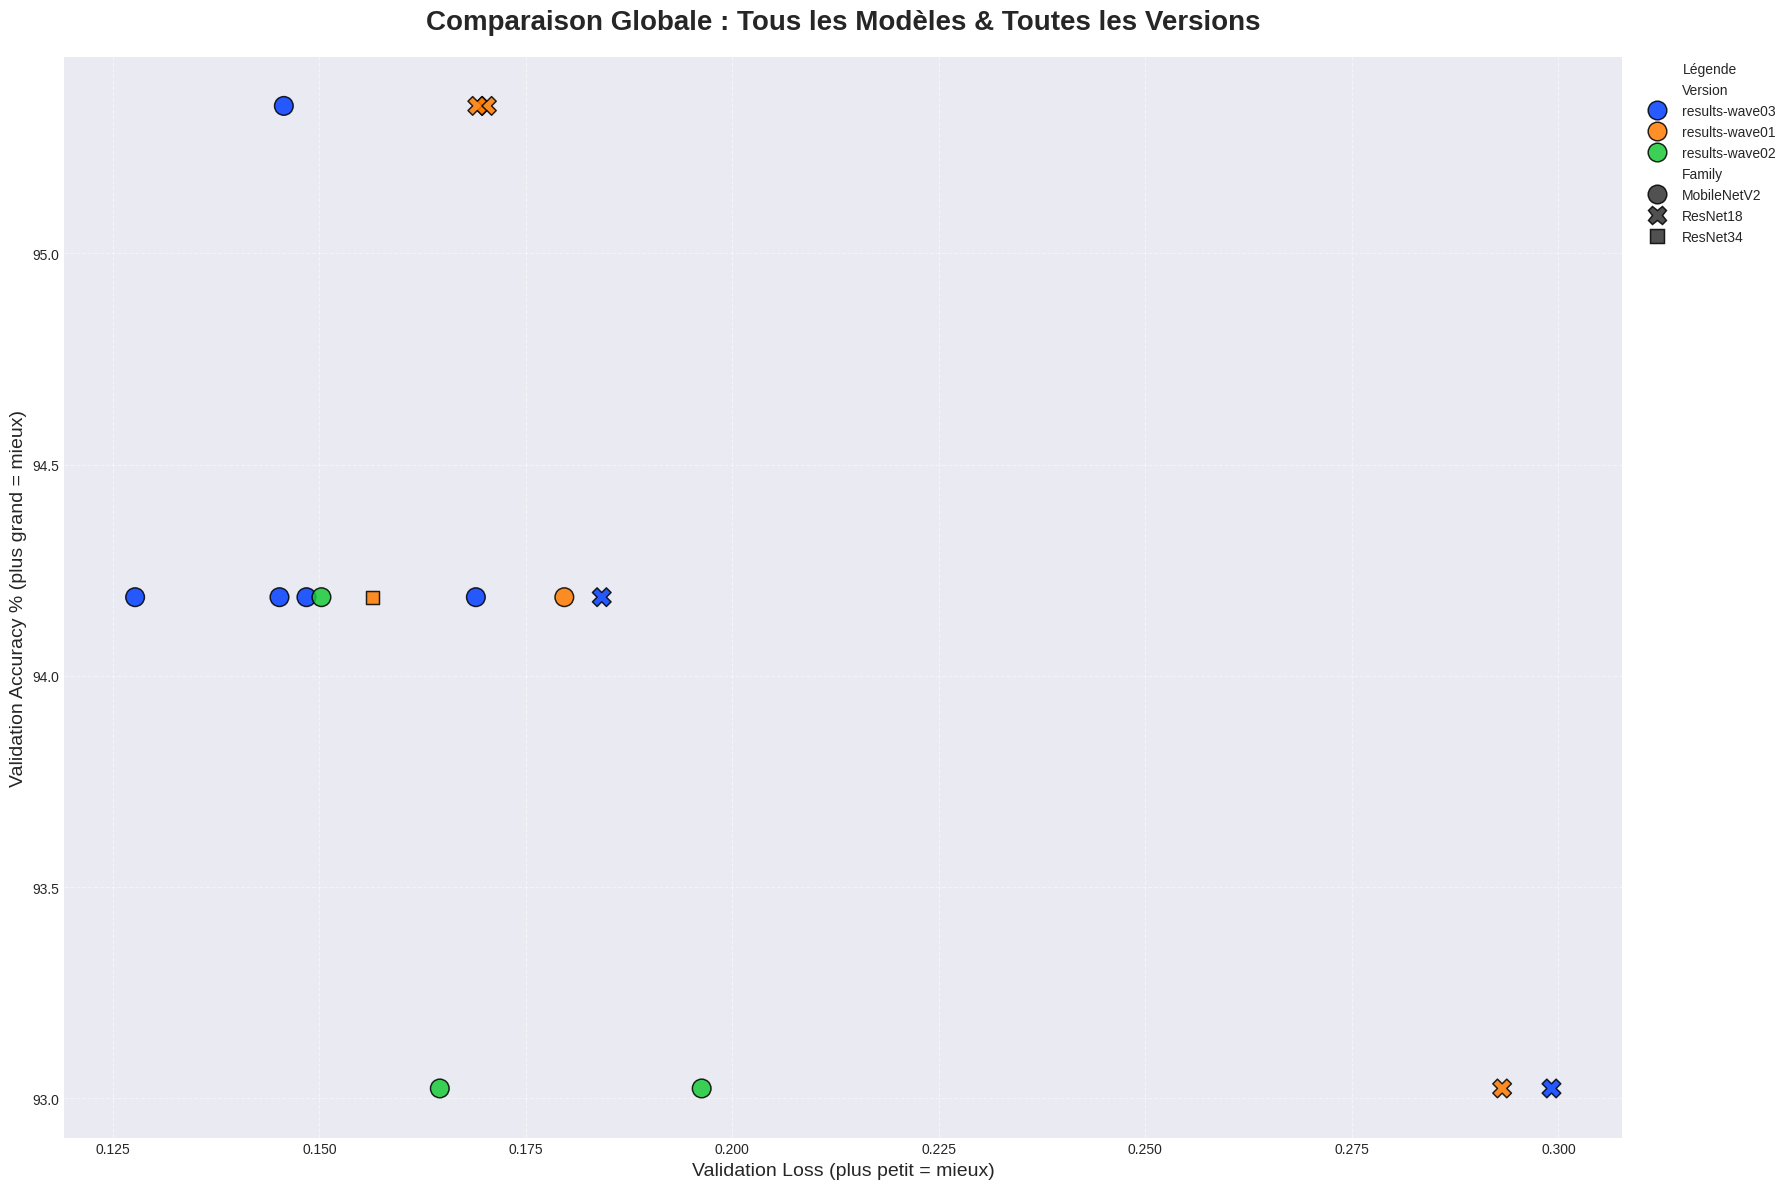

In [ ]:


# Affichage de la liste triée
print(f"\n{'='*100}")
print(f" CLASSEMENT GLOBAL ABSOLU (Top {TOP_N} sur {len(global_ranked)} modèles)")
print(f"{'='*100}\n")

display_cols = ['val_accuracy', 'val_loss', 'Version', 'Family', 'BatchSize', 'LearningRate']
print(global_ranked[display_cols].head(TOP_N))

# 3. Graphique de synthèse
plt.figure(figsize=(18, 12))

# On utilise :
# - HUE (Couleur) pour distinguer les VERSIONS (impact de la campagne d'entrainement)
# - STYLE (Forme) pour distinguer la FAMILLE de modèle (ResNet vs MobileNet...)
# - TAILLE fixe pour la lisibilité
sns.scatterplot(
    data=global_ranked,
    x='val_loss', 
    y='val_accuracy',
    hue='Version',      
    style='Family',     
    s=180,              
    alpha=0.85,
    palette='bright',
    edgecolor='black'
)

# Annotation dynamique des 10 Meilleurs Modèles (toutes versions confondues)
# for i, (model_name, row) in enumerate(global_ranked.head(10).iterrows()):
#     plt.annotate(
#         f"#{i+1} {model_name}", 
#         (row['val_loss'], row['val_accuracy']),
#         xytext=(0, 15 if i % 2 == 0 else -15), # Alterne haut/bas pour éviter le chevauchement
#         textcoords='offset points',
#         fontsize=9, fontweight='bold', ha='center',
#         bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", alpha=0.8)
#     )

plt.title("Comparaison Globale : Tous les Modèles & Toutes les Versions", fontsize=20, fontweight='bold', pad=20)
plt.xlabel("Validation Loss (plus petit = mieux)", fontsize=14)
plt.ylabel("Validation Accuracy % (plus grand = mieux)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

# Légende à l'extérieur
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., title="Légende", fontsize='medium')

plt.tight_layout()
plt.show()



In [11]:
# ...existing code...
# --- AFFICHAGE DETAILLEE DES HYPERPARAMÈTRES (TOP 15 GLOBAUX) ---

print(f"\n{'='*100}")
print(f" ANALYSE DÉTAILLÉE DES HYPERPARAMÈTRES SUR LE TOP {TOP_N} GLOBAL")
print(f"{'='*100}\n")

# On travaille sur le subset des 15 meilleurs modèles
top_models_df = global_ranked.head(TOP_N).copy()

fig, axes = plt.subplots(1, 4, figsize=(32, 7)) # 1 ligne, 4 colonnes

plot_configs = [
    {'col': 'Family',       'title': 'Impact FAMILLE',    'palette': 'bright'},
    {'col': 'BatchSize',    'title': 'Impact BATCH',      'palette': 'viridis'},
    {'col': 'LearningRate', 'title': 'Impact LR',         'palette': 'rocket_r'},
    {'col': 'best_epoch',   'title': 'Impact BEST EPOCH', 'palette': 'flare'}
]

for i, config in enumerate(plot_configs):
    col_name = config['col']
    
    # Tri local pour la légende
    current_data = top_models_df.sort_values(col_name)
    style_param = 'Version' # On utilise la version comme style pour distinguer les vagues
    
    # Scatterplot
    sns.scatterplot(
        data=current_data, 
        x='val_loss', 
        y='val_accuracy', 
        hue=col_name,           # Couleur selon l'hyperparamètre
        style=style_param,      # Forme selon la version
        s=200, 
        alpha=0.8, 
        palette=config['palette'], 
        ax=axes[i],
        edgecolor='black'
    )
    
    axes[i].set_title(f"{config['title']} (Top {TOP_N})", fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Validation Loss')
    axes[i].set_ylabel('Validation Accuracy')
    axes[i].grid(True, alpha=0.3)
    
    # Légende améliorée
    if axes[i].legend_: 
        axes[i].legend(title=col_name, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle(f"Comparaison des Hyperparamètres sur les {TOP_N} Meilleurs Modèles", fontsize=20, y=1.05)
plt.tight_layout()
plt.show()

NameError: name 'TOP_N' is not defined


 COURBES D'APPRENTISSAGE : TOP 15 MEILLEURS MODÈLES GLOBAUX



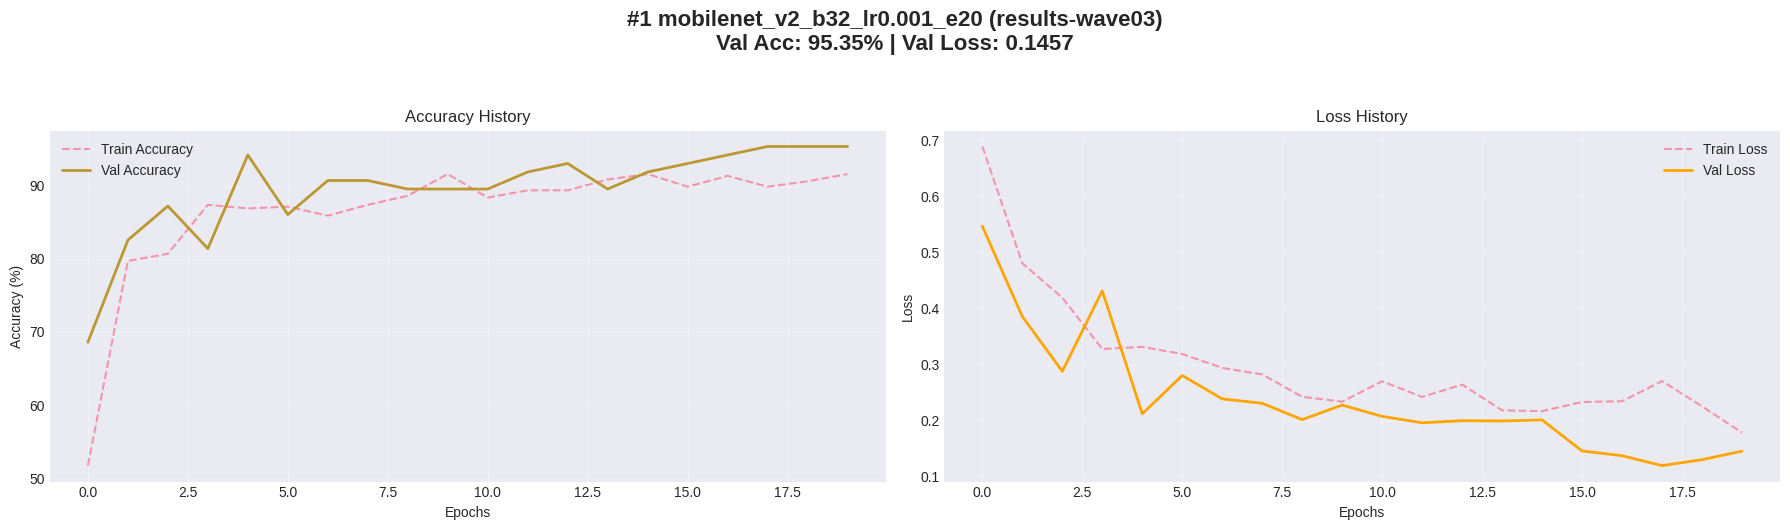

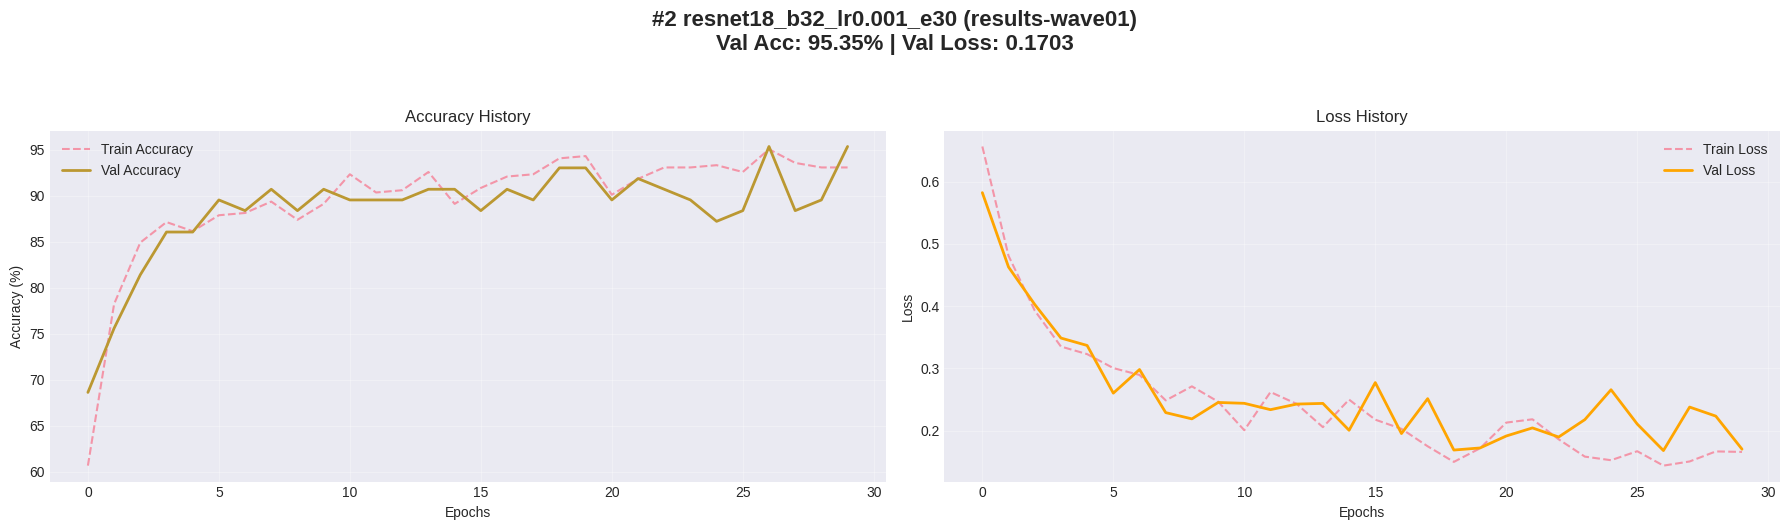

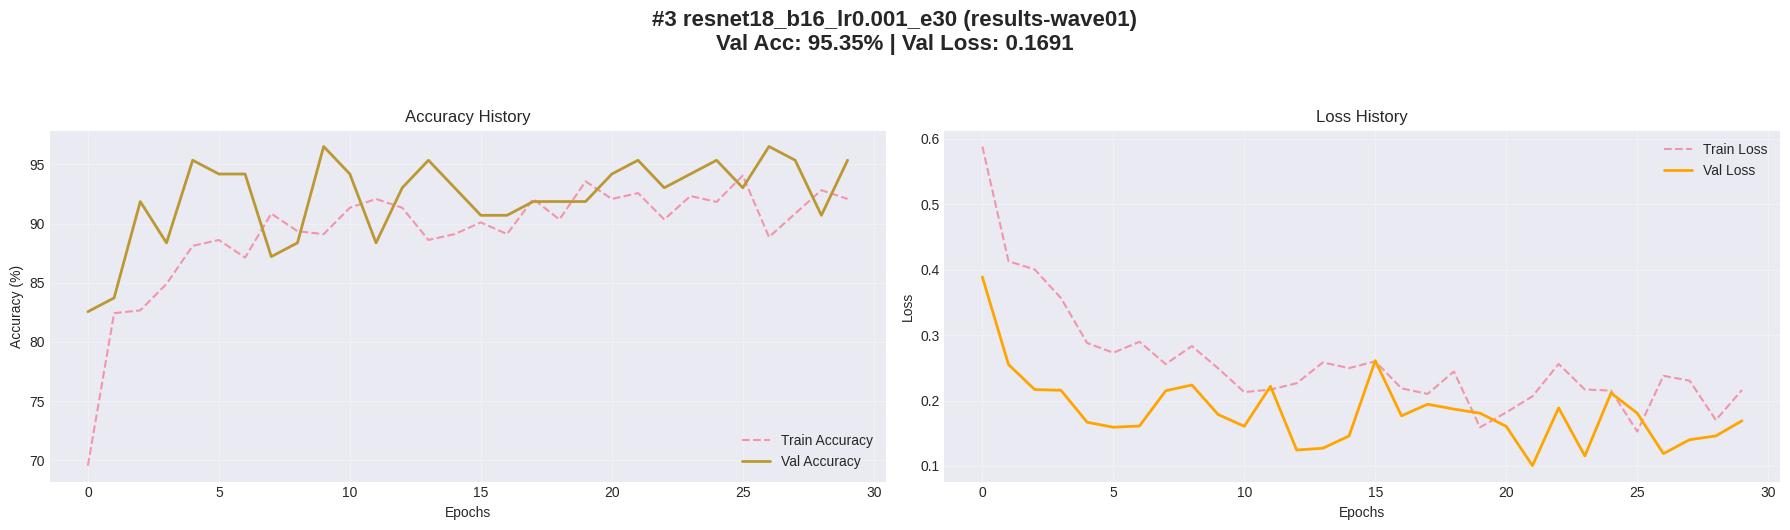

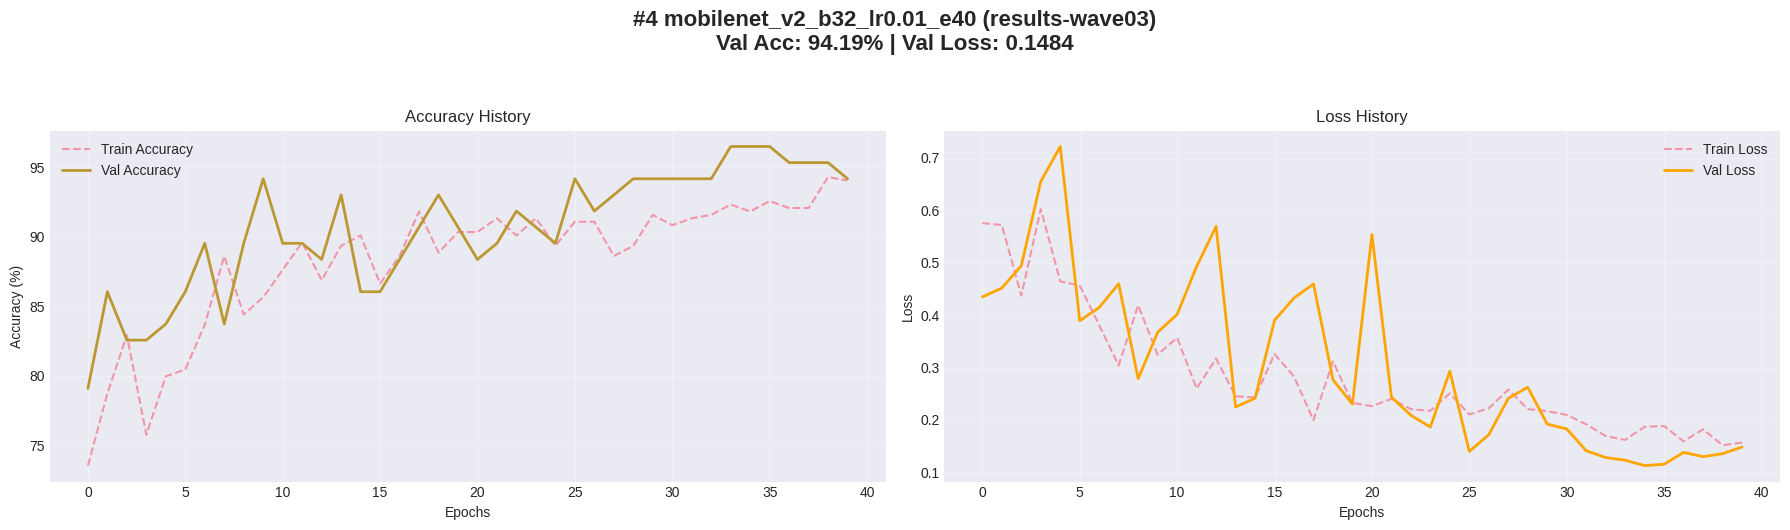

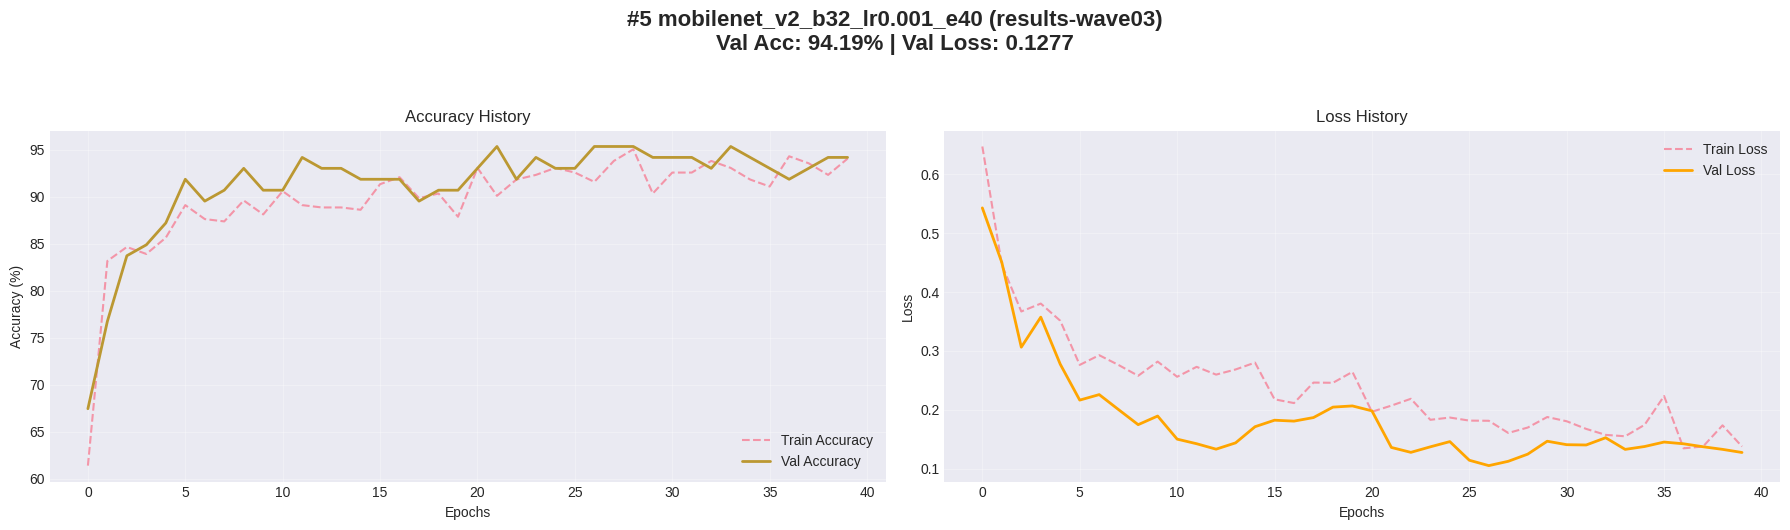

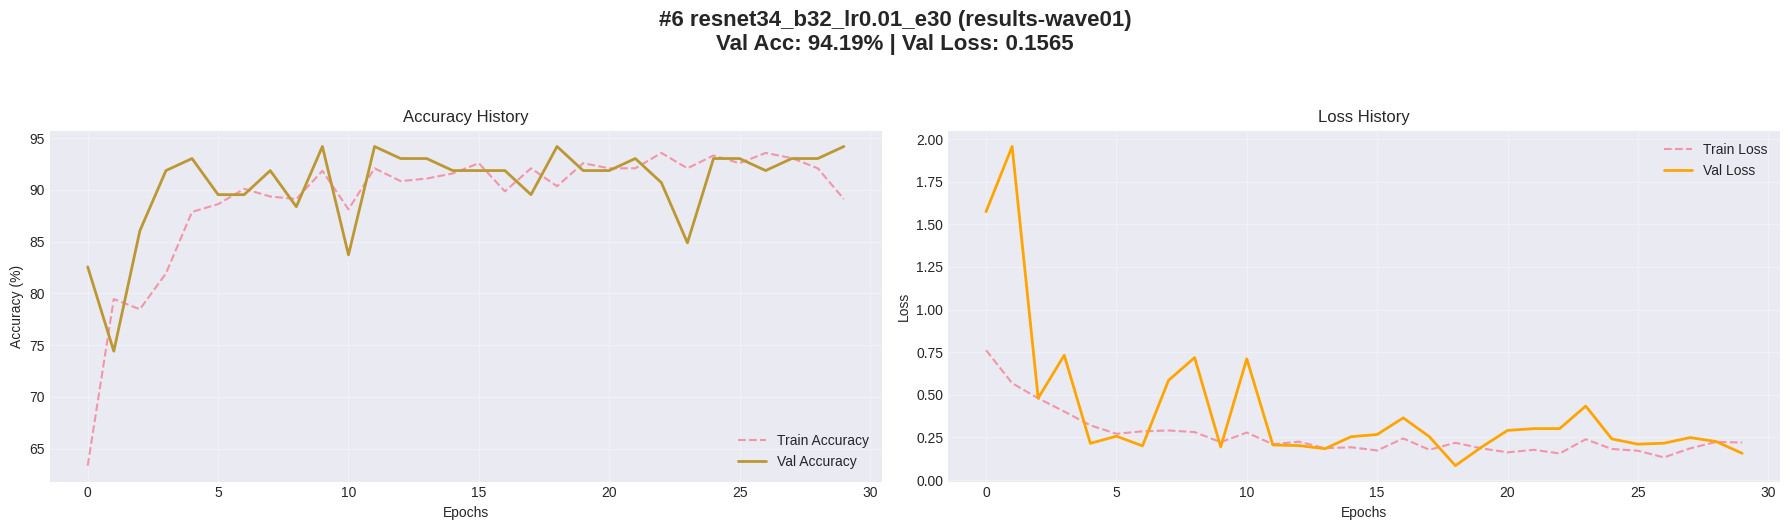

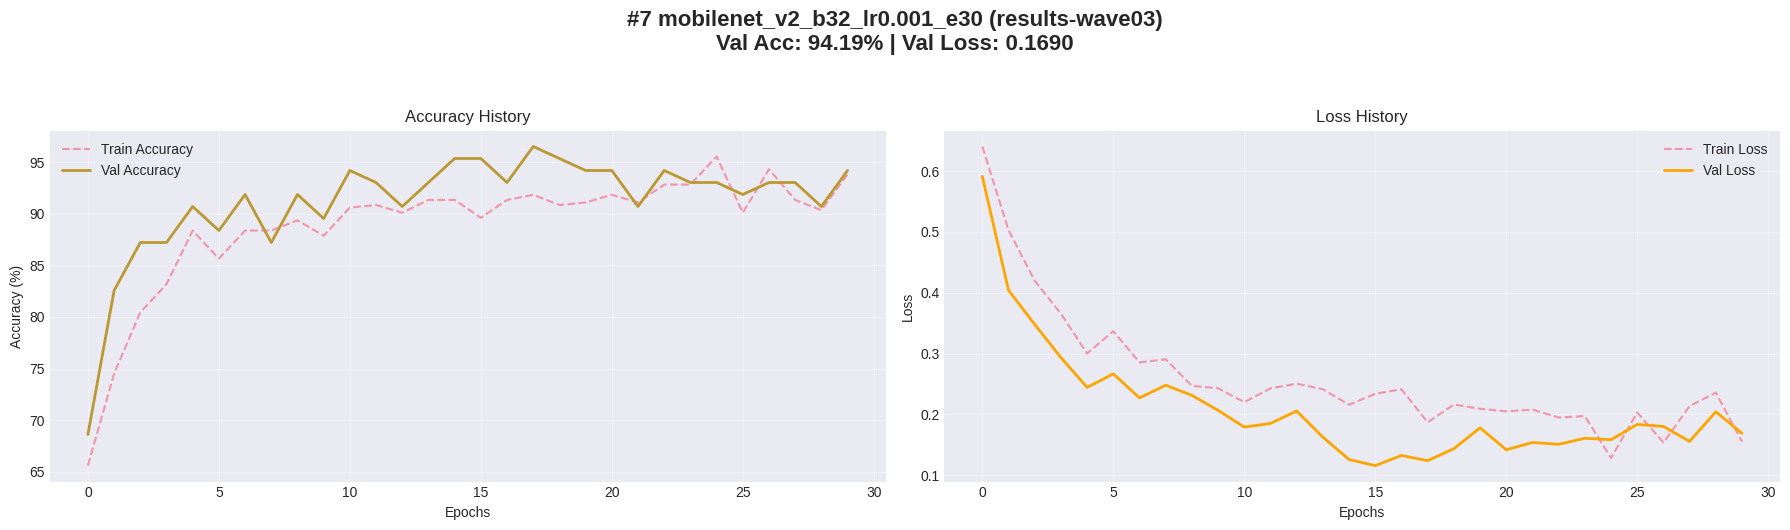

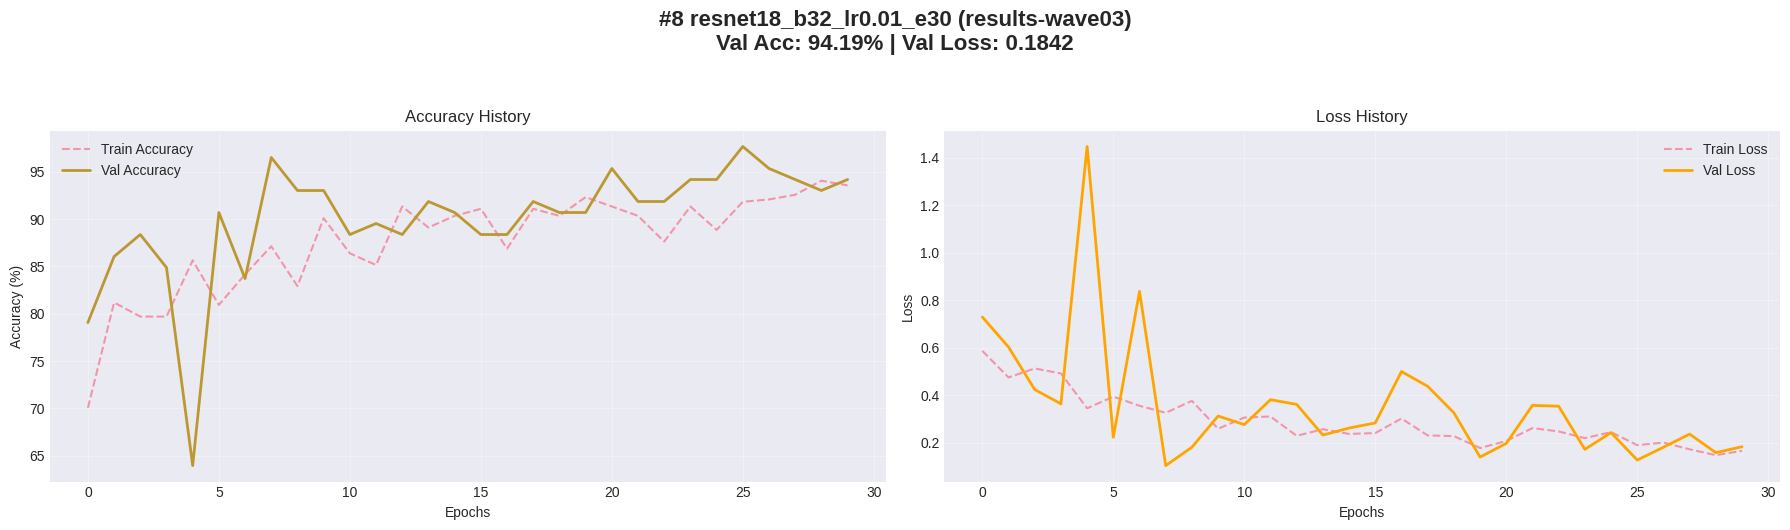

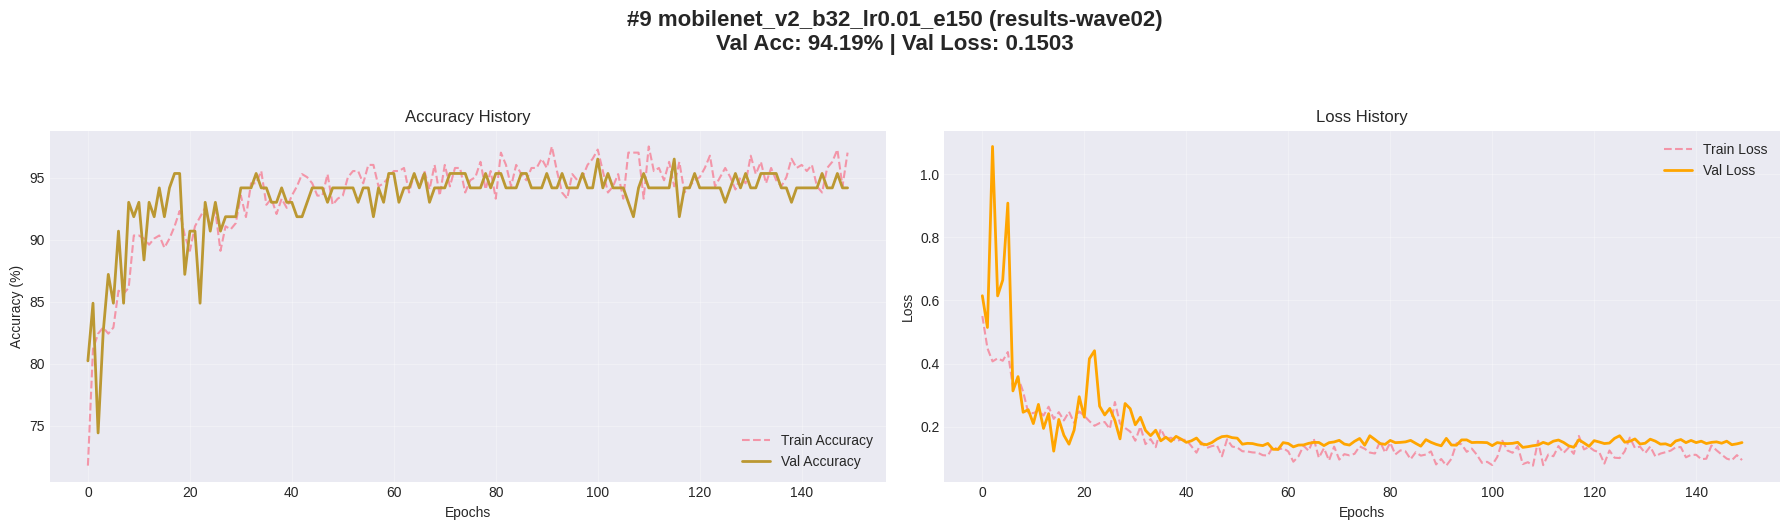

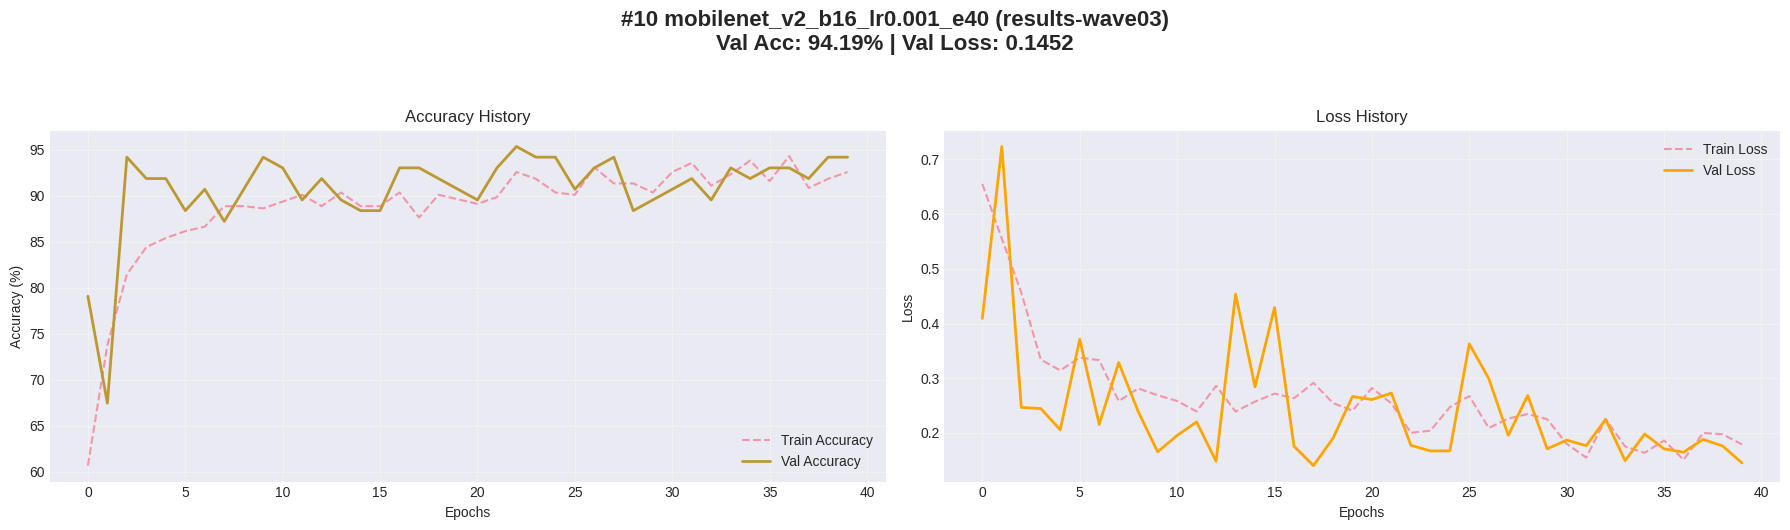

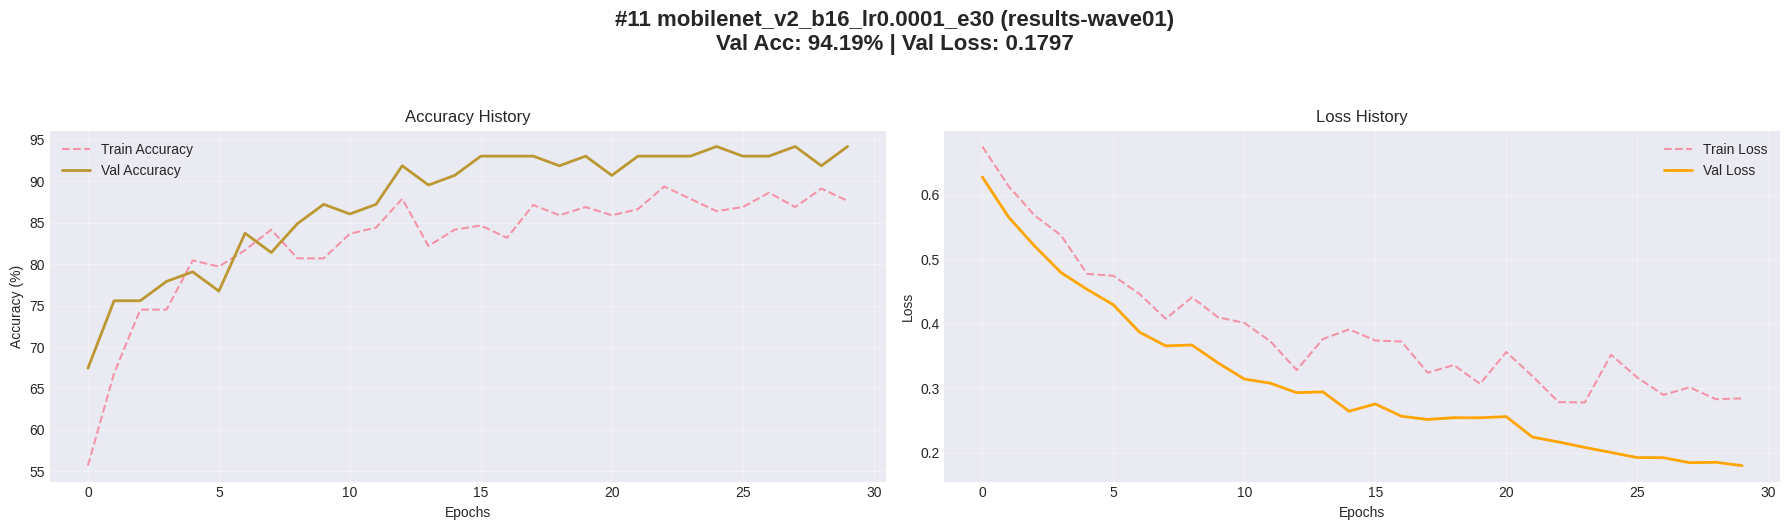

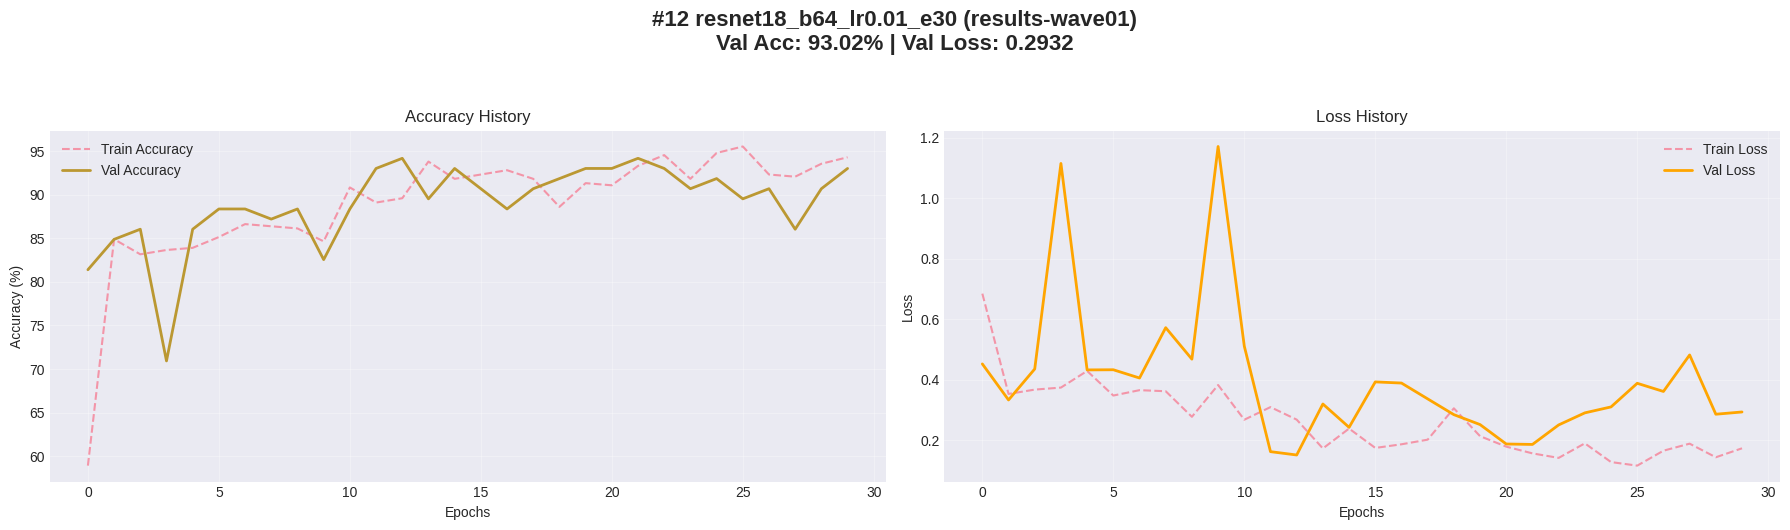

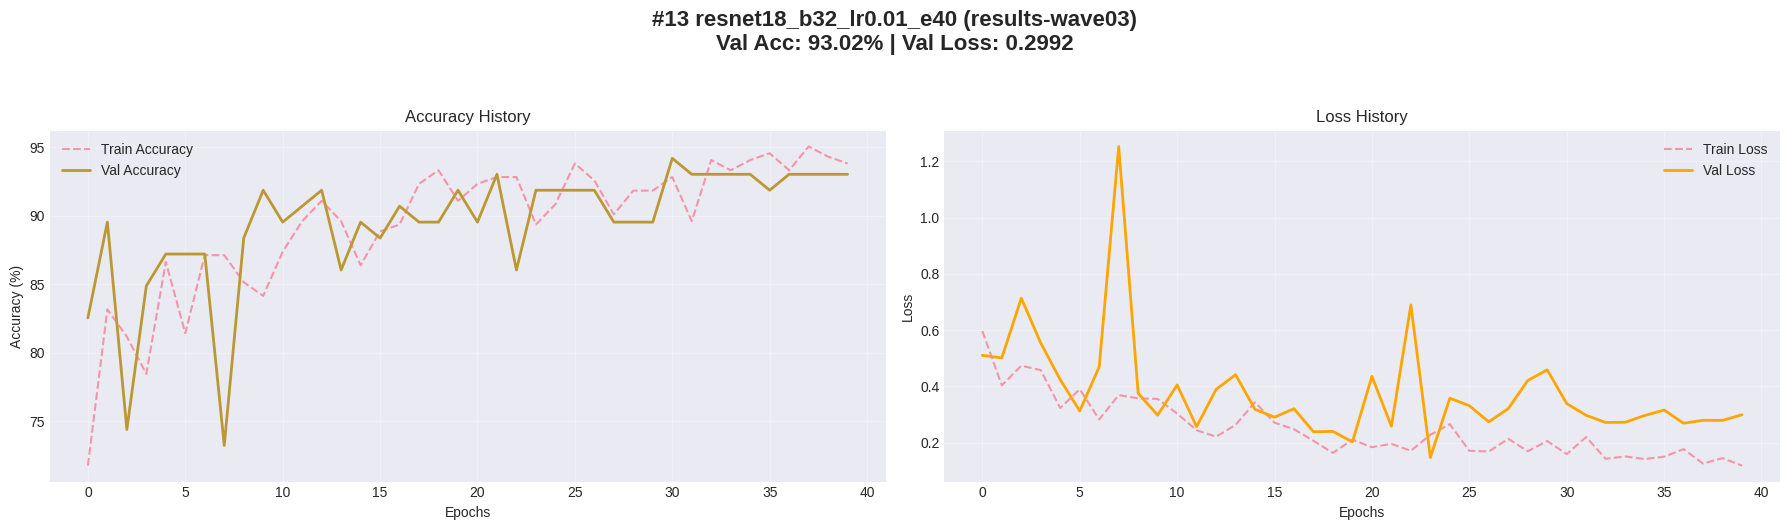

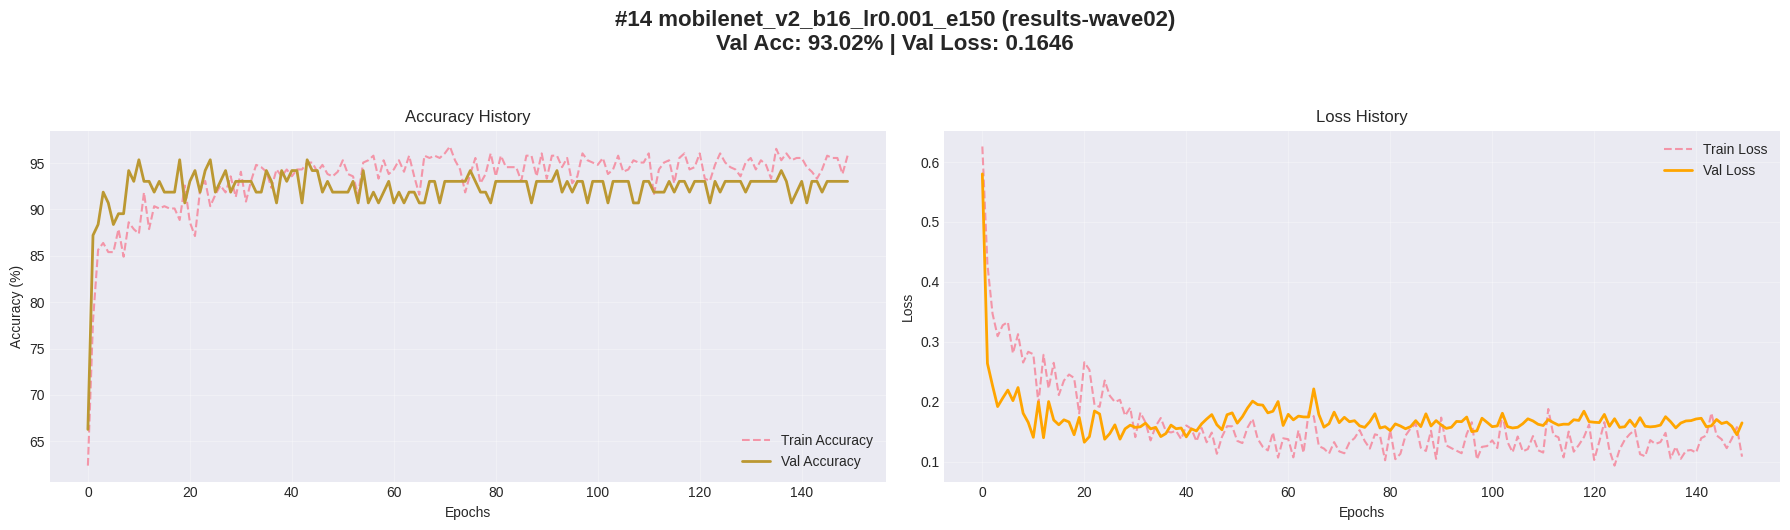

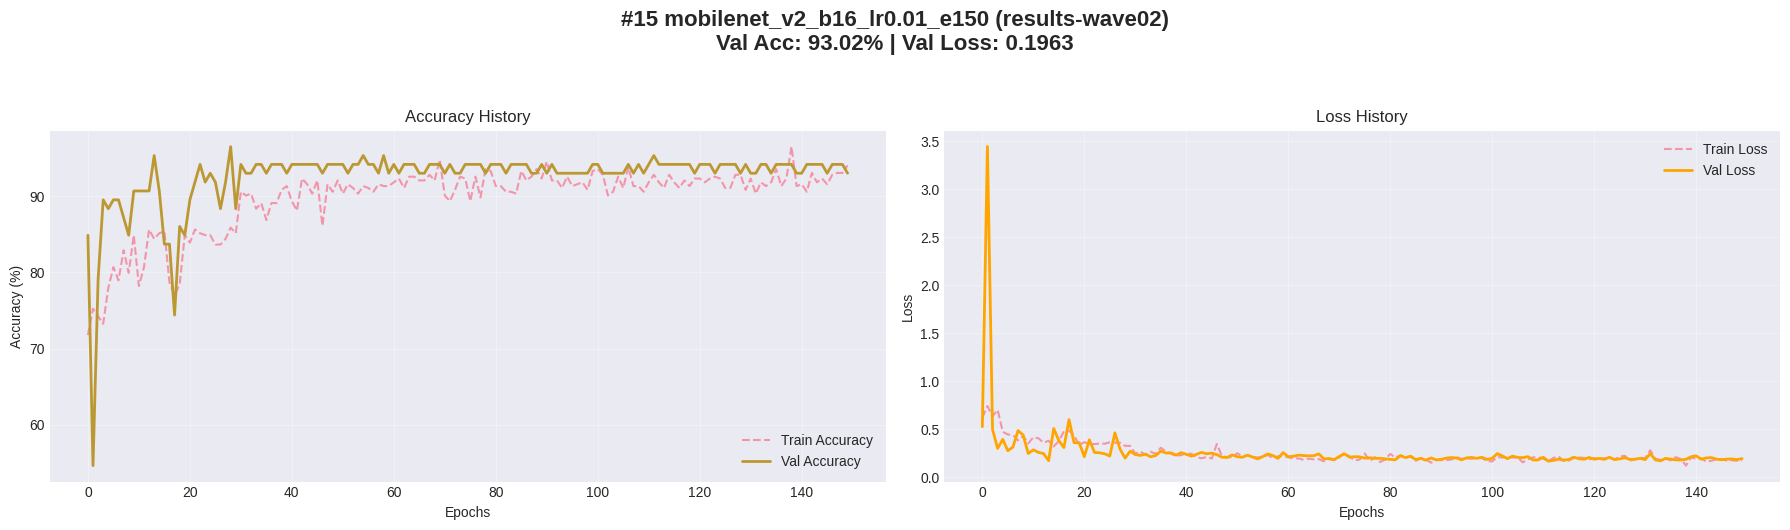

In [ ]:
# ...existing code...
# --- AFFICHAGE DES COURBES D'APPRENTISSAGE POUR LES TOP MODÈLES ---

print(f"\n{'='*100}")
print(f" COURBES D'APPRENTISSAGE : TOP {TOP_N} MEILLEURS MODÈLES GLOBAUX")
print(f"{'='*100}\n")

# On itère sur les N meilleurs du classement global
for i, (model_name, row) in enumerate(global_ranked.head(TOP_N).iterrows()):
    version = row['Version']
    
    # Reconstruction des chemins
    model_path = Path(base_folder) / version / model_name / metrics_folder
    
    # Chargement des historiques
    try:
        t_acc = pd.read_csv(model_path / "train_accuracy.csv", header=None)[0]
        v_acc = pd.read_csv(model_path / "val_accuracy.csv", header=None)[0]
        t_loss = pd.read_csv(model_path / "train_loss.csv", header=None)[0]
        v_loss = pd.read_csv(model_path / "val_loss.csv", header=None)[0]
        
        # Création de la figure (2 graphes côte à côte : Accuracy et Loss)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
        
        # Titre Global avec les performances
        fig.suptitle(f"#{i+1} {model_name} ({version})\n"
                     f"Val Acc: {row['val_accuracy']:.2f}% | Val Loss: {row['val_loss']:.4f}", 
                     fontsize=16, fontweight='bold', y=1.05)
        
        # Graphique Accuracy
        ax1.plot(t_acc, label='Train Accuracy', linestyle='--', alpha=0.7)
        ax1.plot(v_acc, label='Val Accuracy', linewidth=2)
        ax1.set_title('Accuracy History')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Accuracy (%)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Graphique Loss
        ax2.plot(t_loss, label='Train Loss', linestyle='--', alpha=0.7)
        ax2.plot(v_loss, label='Val Loss', linewidth=2, color='orange')
        ax2.set_title('Loss History')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    except FileNotFoundError as e:
        print(f"⚠️ Impossible de charger l'historique pour {model_name} : {e}")